____
# 1. 환경설정

## 1) 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) 한글 출력 세팅

In [3]:
import os
from subprocess import run

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

if not os.path.exists(font_path):
    run(['sudo','apt-get','install','-y','fonts-nanum'], check=True)
    run(['sudo','fc-cache','-fv'], check=True)
    # matplotlib 캐시 지우기
    run(['rm','-rf', os.path.expanduser('~/.cache/matplotlib')], check=True)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings(action='ignore')
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'           # 나눔 고딕
fm.fontManager.addfont(path)
plt.rc('font', family=fm.FontProperties(fname=path, size=10).get_name()) # 기본 폰트 사이즈 : 10

## 3) import

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

___

# 2. 미션 개요

## 1) 목표

- 자전거 대여 패턴을 분석하여 자전거 배치 및 운영 전략을 최적화
- 대여 수요를 정확히 예측
- 이를 통해 대여 시스템의 효율성을 높이고 사용자 만족도 증가시키는 방법 도출

- RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추는 것

## 2) 데이터 설명
- 기간:2011년~2012년 1시간 단위 자전거 대여 데이터 활용

RMSE가 아니라 RMSLE를 적용할 때는 평균보다 매우 높은 상위값들의 예측 오류 영향도가 너무 클 때 이를 상쇄하기 위해 적용한다.

____

# 3. 데이터 분석

## 1) 전처리

### (1) csv 파일 불러오기

In [6]:
import pandas as pd
df_train = pd.read_csv("/content/drive/MyDrive/(개인)AI_3기/Data/미션3/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/(개인)AI_3기/Data/미션3/test.csv")

### (2) 데이터 구조 파악

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [108]:
df_train

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
0,2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0000,3,13,...,False,False,False,False,False,False,False,False,False,False
1,2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0000,8,32,...,False,False,False,False,False,False,False,False,False,False
2,2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0000,5,27,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0000,3,10,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0000,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,15.58,19.695,50,26.0027,7,329,...,False,False,False,False,False,False,False,True,False,False
10882,2012-12-19 20:00:00,0,1,1,14.76,17.425,57,15.0013,10,231,...,False,False,False,False,True,False,False,False,False,False
10883,2012-12-19 21:00:00,0,1,1,13.94,15.910,61,15.0013,4,164,...,False,False,False,False,True,False,False,False,False,False
10884,2012-12-19 22:00:00,0,1,1,13.94,17.425,61,6.0032,12,117,...,False,True,False,False,False,False,False,False,False,False


In [9]:
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


train

    매월 1~19일 데이터
    casual, registered, count(종속변수) 포함

test

    매월 20~31일 데이터
    casual, registered, count 없음

### (3) 결측값 확인

In [10]:
print(df_train.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [11]:
missing_ratio = df_train.isnull().mean().sort_values(ascending=False) # ascending=False : 비율이 큰 것부터 내림차순 정렬
print(missing_ratio)

datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64


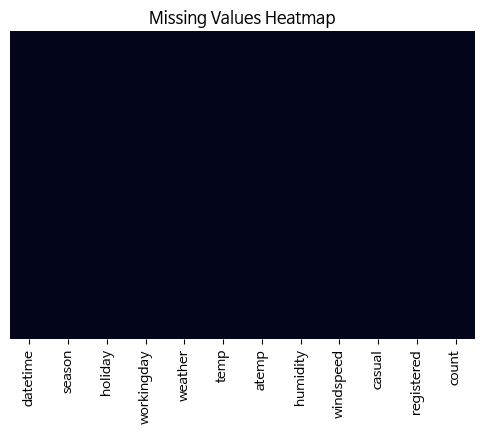

In [12]:
# 결측값 시각화 - 히트맵
plt.figure(figsize=(6,4))
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

### (4) 중복값 확인

In [13]:
df_train[df_train.duplicated()]  # 중복된 행 전체 보기

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


____

In [14]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [15]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [16]:
df_train.describe(include = 'all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,10886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-12-19 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,NaN,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,NaN,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000


## 2) 이상치 찾기

datetime(object) -> year / month / day / hour (int) 형으로 컬럼 만들기

In [17]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_train['year_int'] = df_train['datetime'].dt.year
df_train['month_int'] = df_train['datetime'].dt.month
#df_train['day_int'] = df_train['datetime'].dt.day
df_train['hour_int'] = df_train['datetime'].dt.hour

In [18]:
#print(df_train[['datetime', 'season', 'year_int', 'month_int', 'day_int', 'hour_int']])
print(df_train[['datetime', 'season', 'year_int', 'month_int', 'hour_int']])

                 datetime  season  year_int  month_int  hour_int
0     2011-01-01 00:00:00       1      2011          1         0
1     2011-01-01 01:00:00       1      2011          1         1
2     2011-01-01 02:00:00       1      2011          1         2
3     2011-01-01 03:00:00       1      2011          1         3
4     2011-01-01 04:00:00       1      2011          1         4
...                   ...     ...       ...        ...       ...
10881 2012-12-19 19:00:00       4      2012         12        19
10882 2012-12-19 20:00:00       4      2012         12        20
10883 2012-12-19 21:00:00       4      2012         12        21
10884 2012-12-19 22:00:00       4      2012         12        22
10885 2012-12-19 23:00:00       4      2012         12        23

[10886 rows x 5 columns]


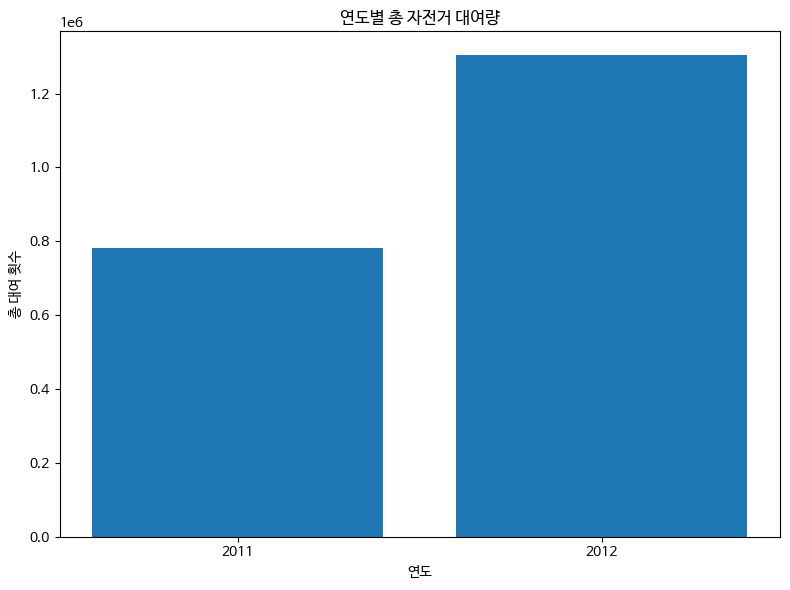

In [19]:
agg = df_train.groupby(df_train['datetime'].dt.year)['count'].sum().reset_index()

# 2) 시각화
plt.figure(figsize=(8,6))
plt.bar(agg['datetime'].astype(str), agg['count'])
plt.xlabel('연도')
plt.ylabel('총 대여 횟수')
plt.title('연도별 총 자전거 대여량')
plt.xticks(agg['datetime'].astype(str))
plt.tight_layout()
plt.show()

2011년보다 2012년에 더 많은 대여량 -> 성장

### (1) casual / registered / count

#### 가. hist + kde

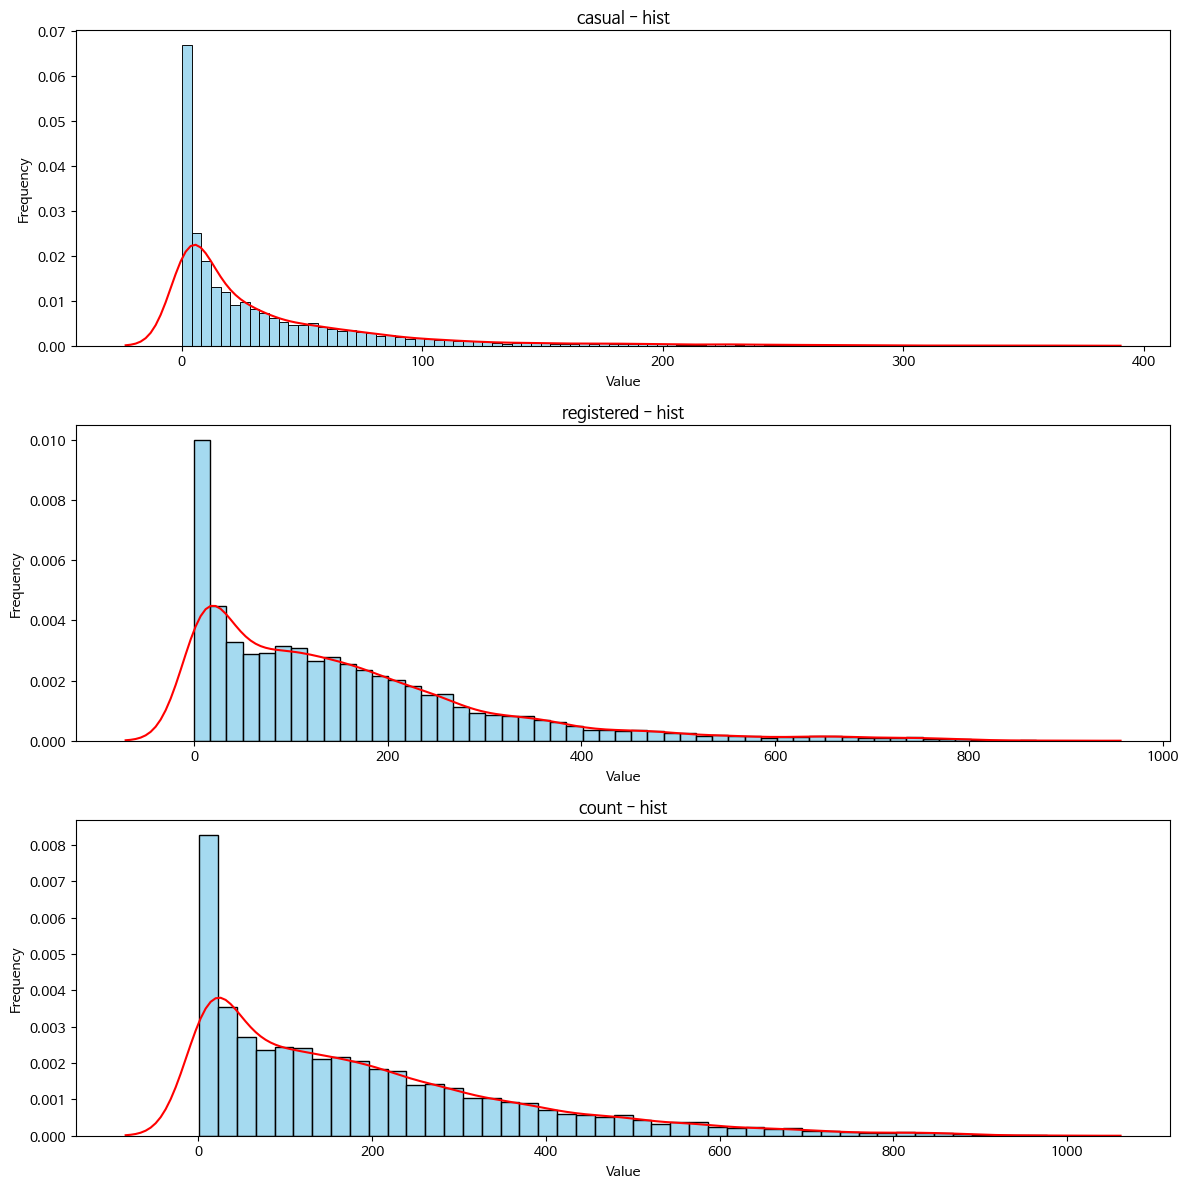

In [20]:
cols = ['casual', 'registered', 'count']

fig = plt.figure(figsize=(12,12))
for i, col in enumerate(cols, start= 1):
    plt.subplot(3, 1, i)
    sns.histplot(x=col, data=df_train, stat='density', color='skyblue', edgecolor='black')
    sns.kdeplot(df_train[col], color='red')
    plt.title(f"{col} - hist")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Right skewed 발생

대부분의 시간대/상황엔 대여량이 적은편

일부 시간대엔 매우 높은 대여량 발생

- 어떤 것이 대여량에 높은 영향을 주는 인사이트인지 확인 필요.

#### 나. 고객 유형 별 총 대여수

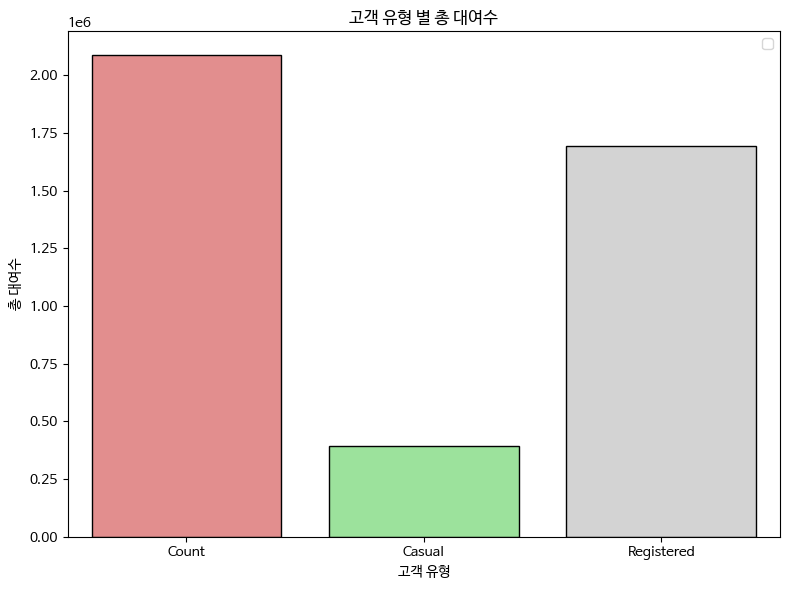

In [21]:
total_count = df_train['count'].sum()
total_casual = df_train['casual'].sum()
total_registered = df_train['registered'].sum()

total_data = {
    "Count": total_count,
    "Casual": total_casual,
    "Registered": total_registered
}

customer_data = pd.DataFrame({
    'Type':    list(total_data.keys()),
    'Rentals': list(total_data.values())
})

plt.figure(figsize=(8,6))
sns.barplot(x='Type', y='Rentals',data=customer_data, palette=['lightcoral','lightgreen','lightgray'],
    edgecolor='black')


plt.legend()
plt.title("고객 유형 별 총 대여수")
plt.xlabel("고객 유형")
plt.ylabel("총 대여수")
plt.tight_layout()
plt.show()

회원고객이 다수

비회원고객이 적다

회원고객과 비회원고객의 이용패턴이 다른지 확인필요

#### 다. 시간대별 그래프

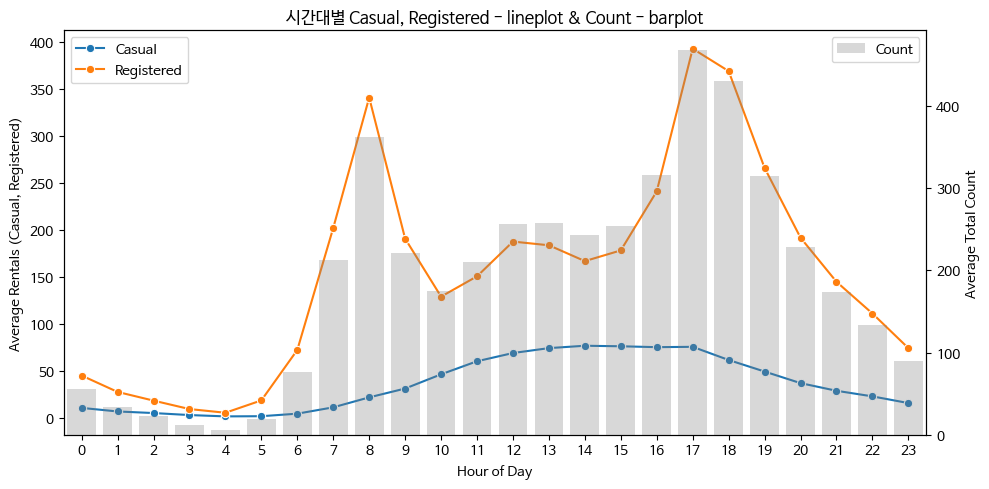

In [22]:
#시간대별로 registered / casual 그래프

agg = df_train.groupby('hour_int')[['casual', 'registered', 'count']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.lineplot(x='hour_int', y='casual', data=agg, marker='o', label='Casual', ax=ax1)
sns.lineplot(x='hour_int', y='registered', data=agg, marker='o', label='Registered', ax=ax1)
ax1.set_ylabel('Average Rentals (Casual, Registered)')
ax1.set_xlabel('Hour of Day')
ax1.set_xticks(range(0, 24))
ax1.legend(loc='upper left')

ax2=ax1.twinx()
sns.barplot(x='hour_int', y='count', data=agg, alpha=0.3, color='gray', label='Count', ax=ax2)
ax2.set_ylabel('Average Total Count')

plt.title("시간대별 Casual, Registered - lineplot & Count - barplot")
plt.legend()
plt.tight_layout()
plt.show()

💡 인사이트

    시간대별 패턴이 뚜렷하게 비선형이다.
    러시아워 시간대(07시, 08시, 09시, 17시, 18시, 19시)가 피크가 크다.
    심야시간대는 적다.


### (2) 범주형 데이터

#### 가. season -> new_season

season의 컬럼이 잘못되어있어서, 재정의

계절 (1\~3: 봄[1], 4\~6: 여름[2], 7\~9: 가을[3], 10\~12: 겨울[4])

->

계절 (3\~5: 봄[1], 6\~8: 여름[2], 9\~11: 가을[3], 12\~2: 겨울[4])

In [23]:
def mapping_new_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

df_train['new_season'] = df_train['month_int'].apply(mapping_new_season)

print(df_train[['month_int', 'season', 'new_season']].drop_duplicates())

      month_int  season  new_season
0             1       1           4
431           2       1           4
877           3       1           1
1323          4       2           1
1778          5       2           1
2234          6       2           2
2690          7       3           2
3146          8       3           2
3602          9       3           3
4055         10       4           3
4510         11       4           3
4966         12       4           4


In [24]:
df_train = df_train.drop(columns=['season'])

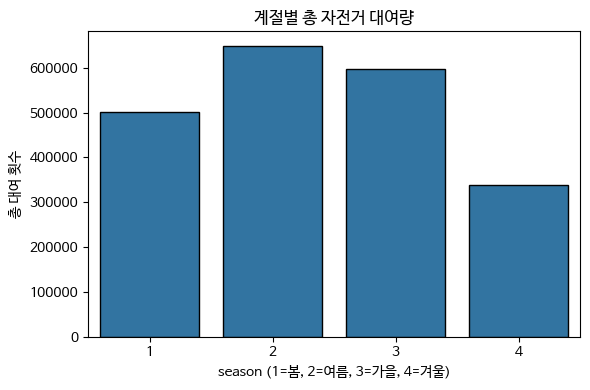

In [25]:
agg = df_train.groupby('new_season')['count'].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(
    x='new_season',
    y='count',
    data=agg,
    edgecolor='black'
)
plt.title('계절별 총 자전거 대여량')
plt.xlabel('season (1=봄, 2=여름, 3=가을, 4=겨울)')
plt.ylabel('총 대여 횟수')
plt.tight_layout()
plt.show()

자전거 타기 좋은 날씨 (여름, 가을, 봄, 겨울 순)으로 이용량의 차이가 있다.

#### 나. holiday, workingday, weather

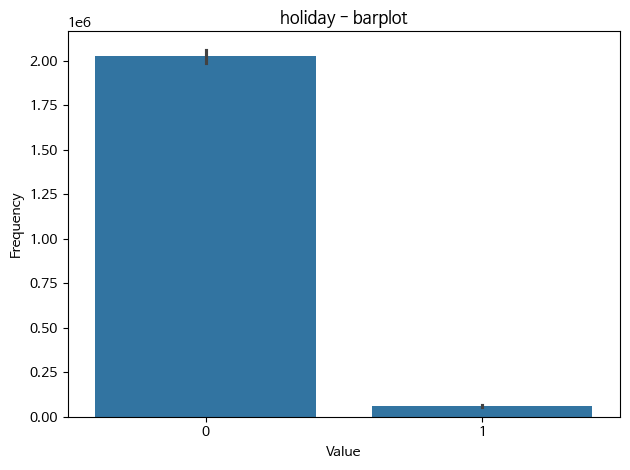

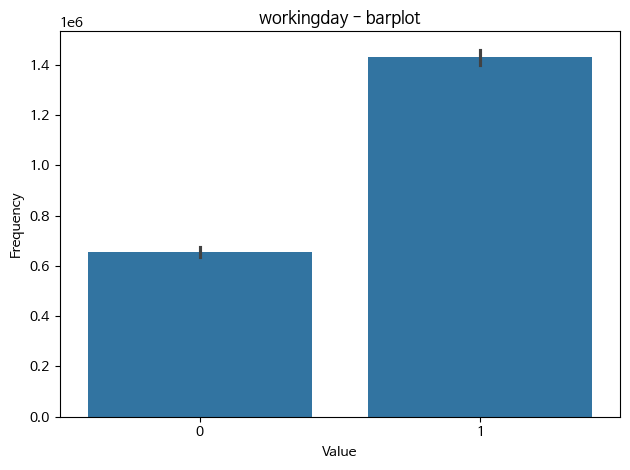

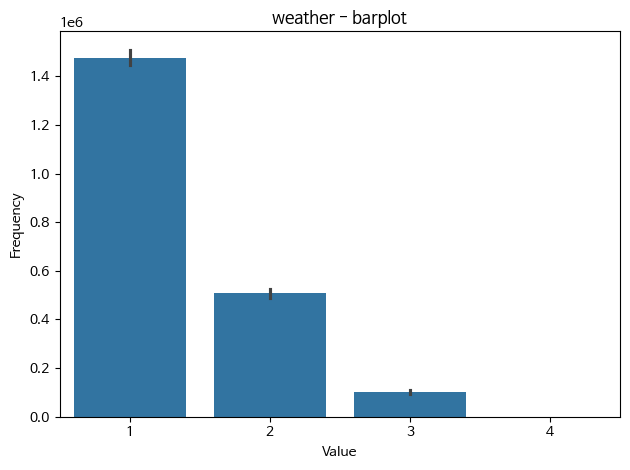

In [26]:
cols = ['holiday', 'workingday', 'weather'] #'temp', 'atemp', 'humidity', 'windspeed'

for i, col in enumerate(cols, start= 1):
    sns.barplot(x=col, y='count', data=df_train, estimator=np.sum) #sns.countplot(x=col, data=df_train)
    plt.title(f"{col} - barplot")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

공휴일이 아닐 때, 근무일일 때, 날씨가 맑을 때 이용량이 많다.

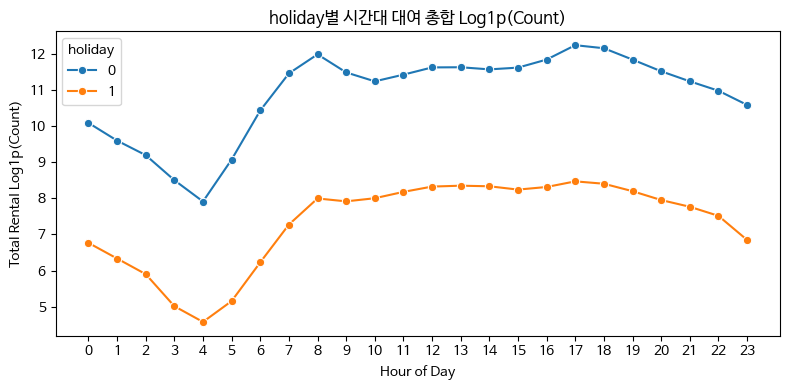

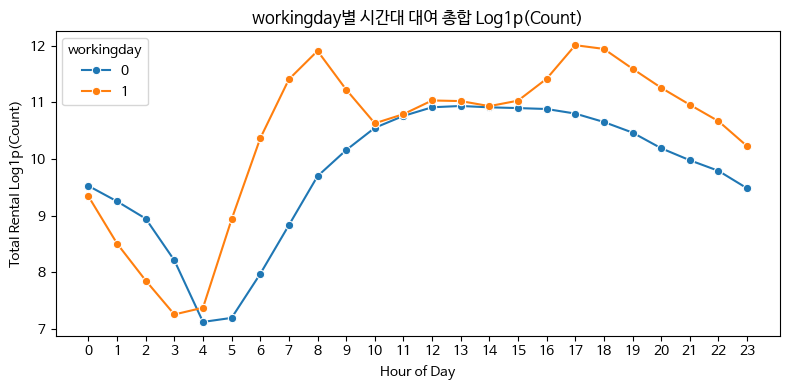

In [27]:
cols = ['holiday', 'workingday']
for col in cols:
    agg = (df_train.groupby(['hour_int', col])['count'].sum().reset_index())
    agg['count_log'] = np.log1p(agg['count'])

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=agg, x='hour_int', y='count_log', hue=col, marker='o')

    plt.title(f"{col}별 시간대 대여 총합 Log1p(Count)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Total Rental Log1p(Count)")
    plt.xticks(range(24))
    plt.legend(title=col)
    plt.tight_layout()
    plt.show()

일할 때는 출퇴근시간(07 \~ 09시, 16 \~ 19시)가 이용량이 급격히 많고,

쉬는 날엔 낮시간(12~16시)가 이용량이 많다.

### (3) 수치형 데이터

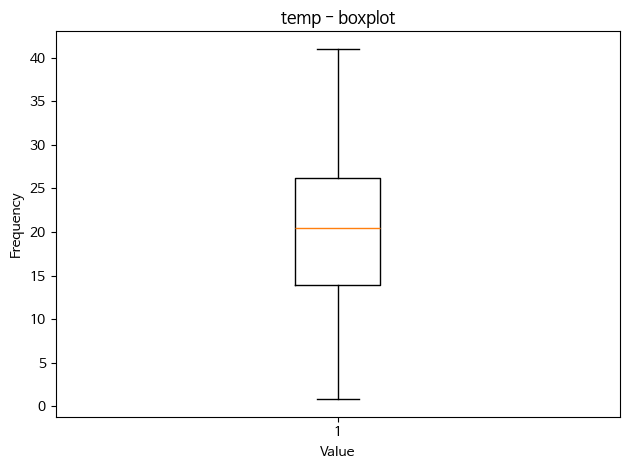

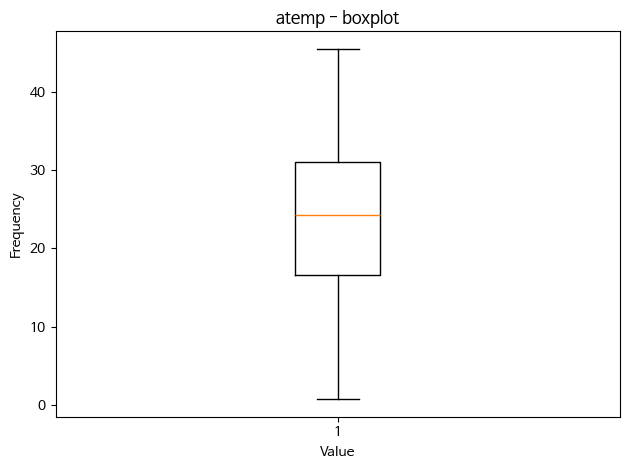

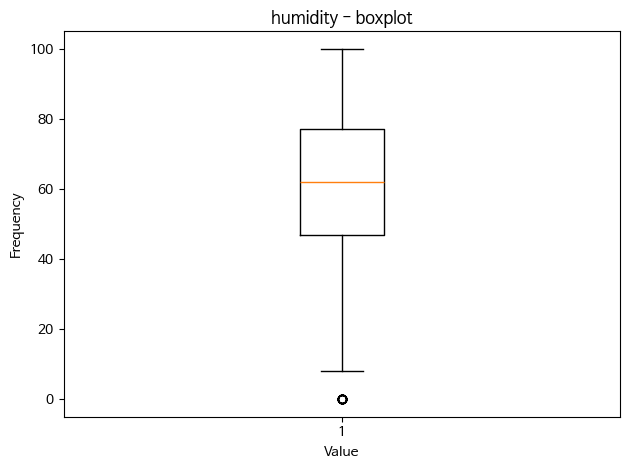

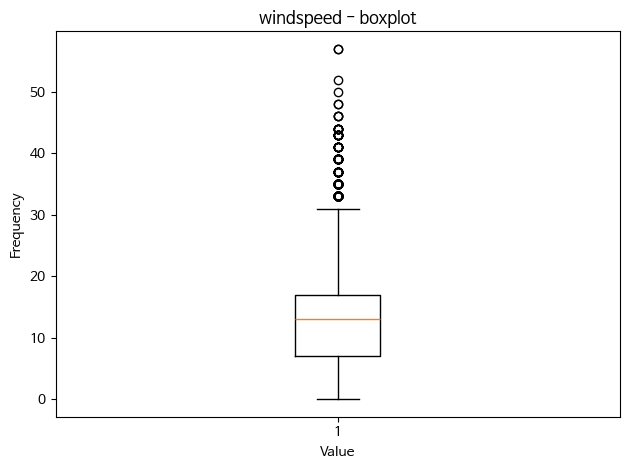

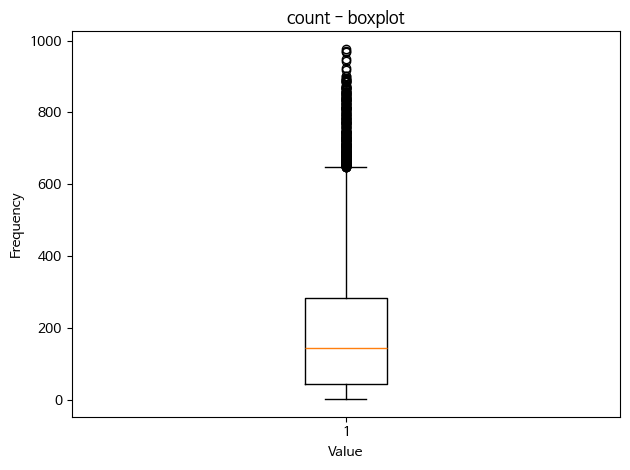

In [28]:
cols = ['temp', 'atemp', 'humidity', 'windspeed', 'count']

for i, col in enumerate(cols, start= 1):
    plt.boxplot(df_train[col])
    plt.title(f"{col} - boxplot")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#### 가. humidity

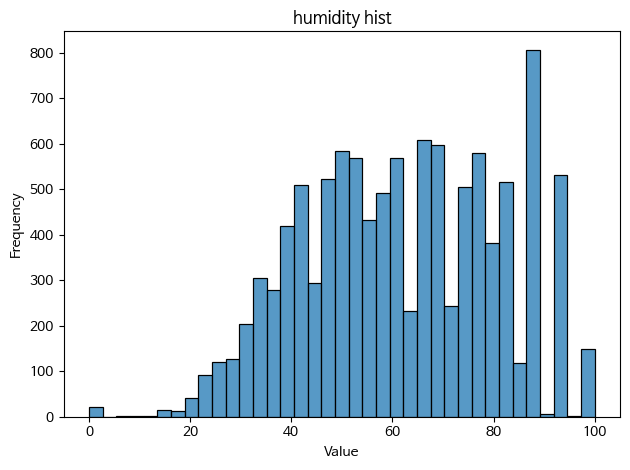

In [29]:
sns.histplot(x='humidity', data=df_train)
plt.title("humidity hist")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [30]:
low_humidity = df_train[df_train['humidity']<=20].sort_values(by='humidity', ascending=True)
low_humidity.head(50)

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_int,month_int,hour_int,new_season
1091,2011-03-10 00:00:00,0,1,3,13.94,15.910,0,16.9979,3,0,3,2011,3,0,1
1092,2011-03-10 01:00:00,0,1,3,13.94,15.910,0,16.9979,0,2,2,2011,3,1,1
1093,2011-03-10 02:00:00,0,1,3,13.94,15.910,0,16.9979,0,1,1,2011,3,2,1
1106,2011-03-10 17:00:00,0,1,2,18.04,21.970,0,26.0027,2,109,111,2011,3,17,1
1105,2011-03-10 16:00:00,0,1,3,17.22,21.210,0,16.9979,1,20,21,2011,3,16,1
1104,2011-03-10 15:00:00,0,1,3,18.04,21.970,0,15.0013,3,11,14,2011,3,15,1
1103,2011-03-10 14:00:00,0,1,3,18.04,21.970,0,19.9995,0,12,12,2011,3,14,1
1102,2011-03-10 13:00:00,0,1,3,17.22,21.210,0,15.0013,1,11,12,2011,3,13,1
1101,2011-03-10 12:00:00,0,1,3,17.22,21.210,0,15.0013,4,30,34,2011,3,12,1
1100,2011-03-10 11:00:00,0,1,3,16.40,20.455,0,16.9979,6,5,11,2011,3,11,1


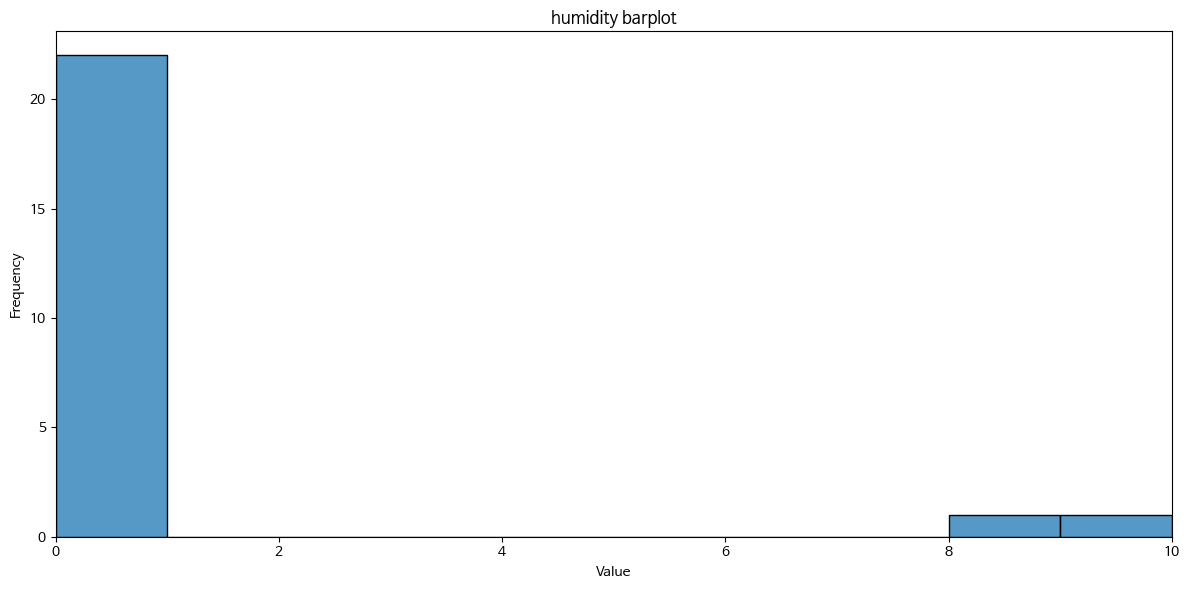

In [31]:
filter_humidity = df_train[df_train['humidity'].between(0,10)]

plt.figure(figsize=(12,6))
sns.histplot(x='humidity', data=filter_humidity, bins = 10)

plt.xlim(0, 10)
plt.title("humidity barplot")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

습도 0%는 나올 수 없으므로 이상치로 데이터 제거한다.

In [32]:
df_train = df_train.drop(df_train[df_train['humidity'] == 0].index)

In [33]:
(df_train['humidity']==0).sum()

np.int64(0)

#### 나. temp

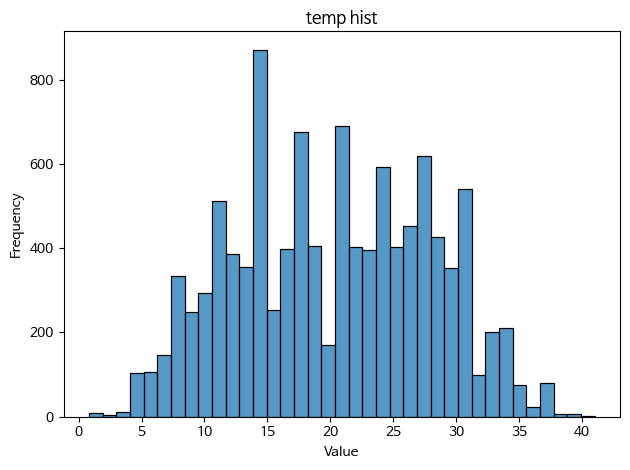

In [34]:
sns.histplot(x='temp', data=df_train)
plt.title("temp hist")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

_____

#### 다. windspeed

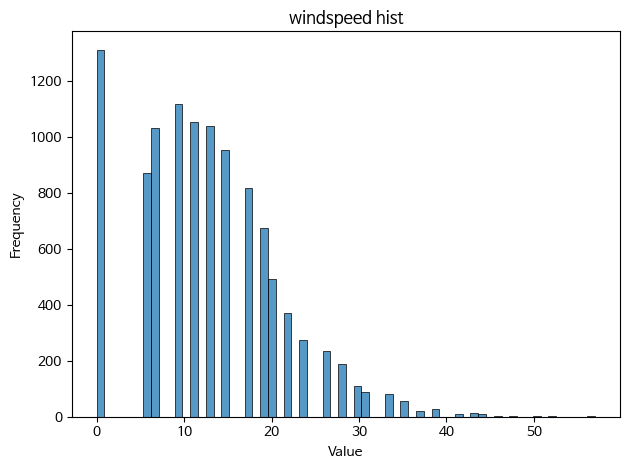

In [35]:
sns.histplot(x='windspeed', data=df_train)
plt.title("windspeed hist")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

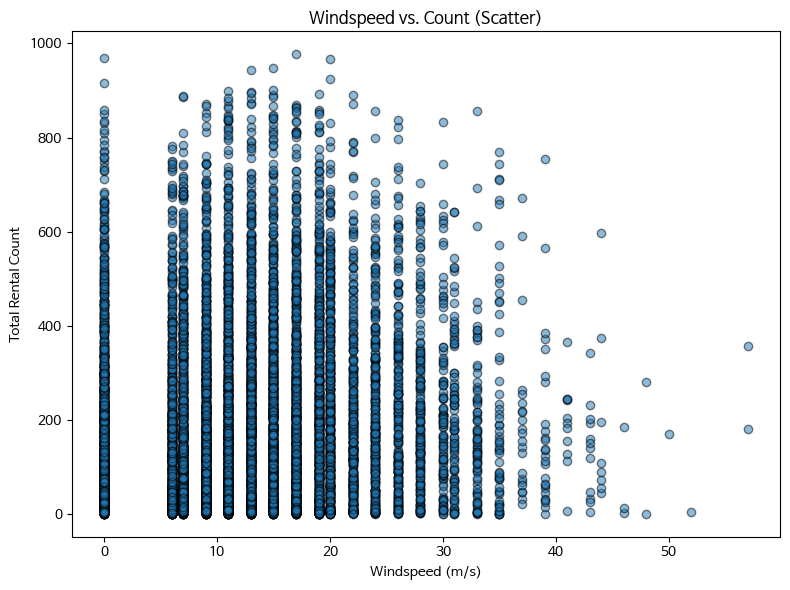

In [36]:

plt.figure(figsize=(8,6))
plt.scatter(
    df_train['windspeed'],
    df_train['count'],
    alpha=0.5,
    edgecolor='k'
)
plt.title('Windspeed vs. Count (Scatter)')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Total Rental Count')
plt.tight_layout()
plt.show()

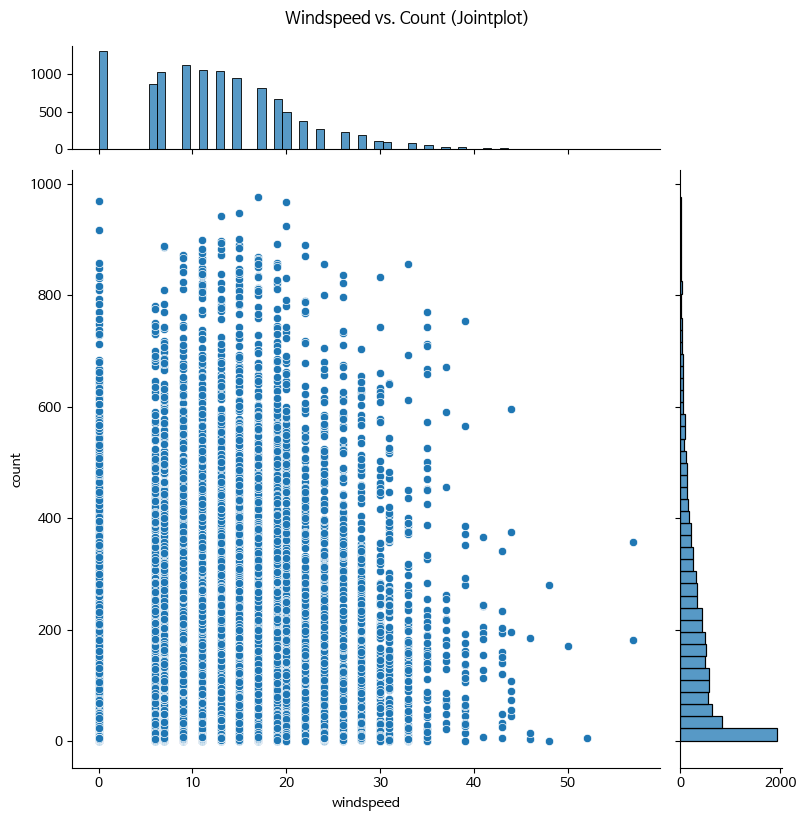

In [37]:
sns.jointplot(
    x='windspeed',
    y='count',
    data=df_train,
    kind='scatter',
    height=8,
    marginal_ticks=True
)
plt.suptitle('Windspeed vs. Count (Jointplot)', y=1.02)
plt.show()

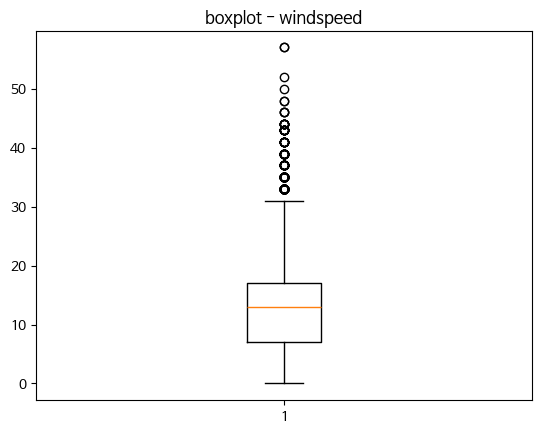

In [38]:
plt.boxplot(df_train["windspeed"])
plt.title("boxplot - windspeed")
plt.show()

In [39]:
high_windspeed = df_train[df_train['windspeed']>=20].sort_values(by='windspeed', ascending=False)
high_windspeed.head(100)

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_int,month_int,hour_int,new_season
2756,2011-07-03 18:00:00,0,0,3,32.80,37.120,49,56.9969,74,107,181,2011,7,18,2
2755,2011-07-03 17:00:00,0,0,3,32.80,37.120,49,56.9969,181,177,358,2011,7,17,2
760,2011-02-15 01:00:00,0,1,1,12.30,12.120,42,51.9987,0,5,5,2011,2,1,4
868,2011-02-19 15:00:00,0,0,1,18.04,21.970,16,50.0021,84,87,171,2011,2,15,4
6142,2012-02-12 04:00:00,0,0,2,4.10,2.275,46,47.9988,0,1,1,2012,2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,2012-02-02 20:00:00,0,1,1,14.76,15.910,46,35.0008,9,204,213,2012,2,20,4
5918,2012-02-02 19:00:00,0,1,1,15.58,19.695,43,35.0008,16,311,327,2012,2,19,4
9244,2012-09-08 13:00:00,0,0,1,33.62,38.635,52,35.0008,233,435,668,2012,9,13,3
7017,2012-04-10 17:00:00,0,1,1,22.96,26.515,21,35.0008,88,656,744,2012,4,17,1


풍속이 낮을수록 대여 건수가 많음.

풍속이 높아질수록 대여 건수가 감소한다.

바람이 강할수록 자전거를 덜 빌린다. -> 뚜렷한 음의 상관관계이다.

바람세기가 IQR을 넘는 데이터가 꽤 된다.

https://en.wikipedia.org/wiki/Beaufort_scale

보버트 풍력

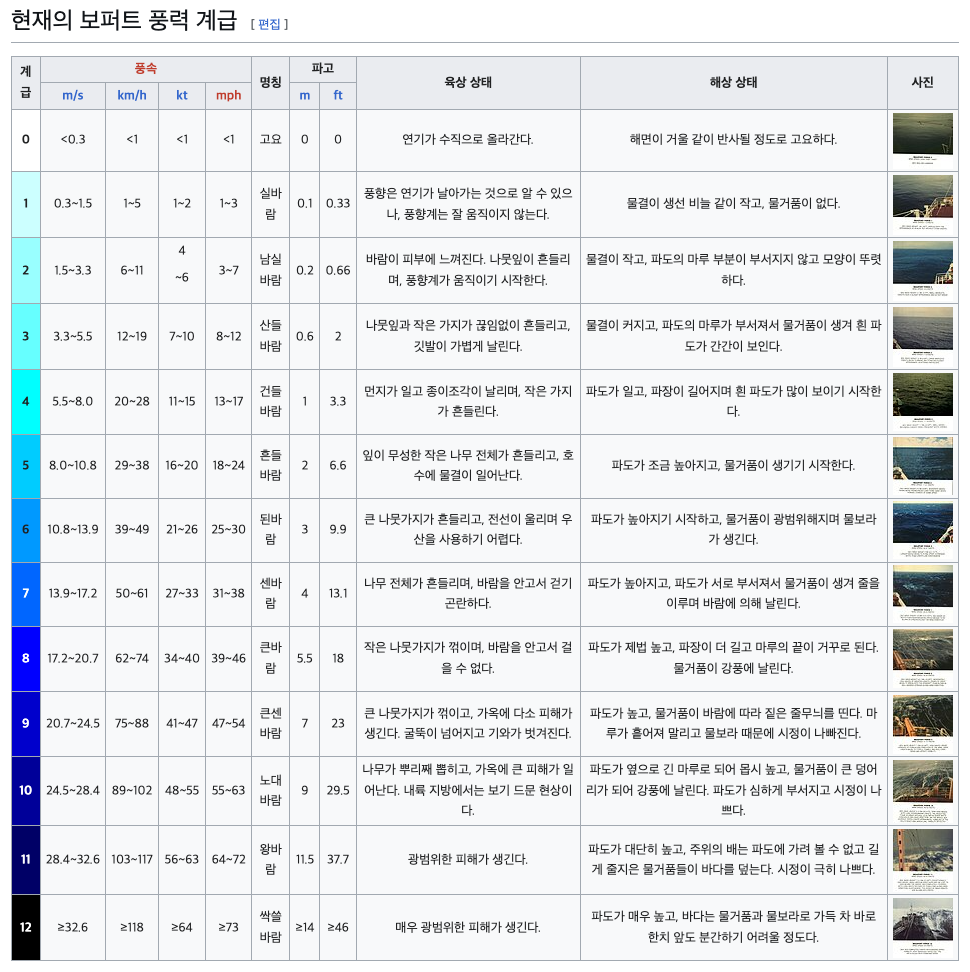

In [40]:
# 0–12급 Beaufort 기준(m/s)
bins = [0, 0.3, 1.5, 3.3, 5.5, 8.0, 10.8, 13.9, 17.2, 20.7, 24.5, 28.4, 32.6, np.inf]
labels = list(range(13))

df_train['beaufort'] = pd.cut(
    df_train['windspeed'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# one-hot 인코딩
df_train = pd.get_dummies(df_train, columns=['beaufort'], prefix='bf')

In [41]:
df_train

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
0,2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0000,3,13,...,False,False,False,False,False,False,False,False,False,False
1,2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0000,8,32,...,False,False,False,False,False,False,False,False,False,False
2,2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0000,5,27,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0000,3,10,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0000,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,15.58,19.695,50,26.0027,7,329,...,False,False,False,False,False,False,False,True,False,False
10882,2012-12-19 20:00:00,0,1,1,14.76,17.425,57,15.0013,10,231,...,False,False,False,False,True,False,False,False,False,False
10883,2012-12-19 21:00:00,0,1,1,13.94,15.910,61,15.0013,4,164,...,False,False,False,False,True,False,False,False,False,False
10884,2012-12-19 22:00:00,0,1,1,13.94,17.425,61,6.0032,12,117,...,False,True,False,False,False,False,False,False,False,False


In [42]:
bf_cols = [c for c in df_train.columns if c.startswith('bf_')]
counts = df_train[bf_cols].sum()
counts.index = counts.index.str.replace('bf_', '').astype(int)
counts = counts.sort_index()

print(counts)

0     1313
1        0
2        0
3        0
4     1905
5     1119
6     2097
7     1774
8     1166
9      643
10     421
11     200
12     226
dtype: int64


In [43]:
q1 = df_train['windspeed'].quantile(0.25)
q3 = df_train['windspeed'].quantile(0.75)

IQR = q3 - q1

# 이상점 조건 설정
outliers = (df_train['windspeed'] < (q1 - 1.5 * IQR)) | (df_train['windspeed'] > (q3 + 1.5 * IQR))

# 이상치점 개수 확인
print("이상점 개수: ", outliers.sum())

이상점 개수:  226


In [44]:
print(df_train[outliers]["windspeed"])

175      32.9975
178      36.9974
194      35.0008
196      35.0008
265      39.0007
          ...   
10013    32.9975
10154    32.9975
10263    43.0006
10540    32.9975
10853    32.9975
Name: windspeed, Length: 226, dtype: float64


In [45]:
df_train = df_train[~outliers]

In [46]:
df_train

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
0,2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0000,3,13,...,False,False,False,False,False,False,False,False,False,False
1,2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0000,8,32,...,False,False,False,False,False,False,False,False,False,False
2,2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0000,5,27,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0000,3,10,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0000,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,0,1,1,15.58,19.695,50,26.0027,7,329,...,False,False,False,False,False,False,False,True,False,False
10882,2012-12-19 20:00:00,0,1,1,14.76,17.425,57,15.0013,10,231,...,False,False,False,False,True,False,False,False,False,False
10883,2012-12-19 21:00:00,0,1,1,13.94,15.910,61,15.0013,4,164,...,False,False,False,False,True,False,False,False,False,False
10884,2012-12-19 22:00:00,0,1,1,13.94,17.425,61,6.0032,12,117,...,False,True,False,False,False,False,False,False,False,False


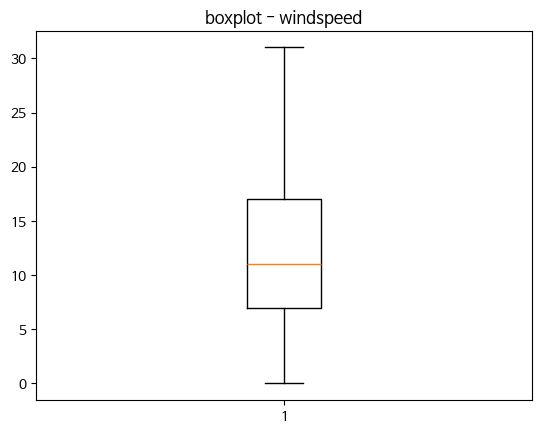

In [47]:
plt.boxplot(df_train["windspeed"])
plt.title("boxplot - windspeed")
plt.show()

In [48]:
10638/10864*100

97.91973490427098

이상치 이상의 값은 지우고, 보퍼트 풍력 계급에 맞춰 데이터를 잘라 범주형 데이터로 만들고, One-Hot encoding한다.

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 10885
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10638 non-null  datetime64[ns]
 1   holiday     10638 non-null  int64         
 2   workingday  10638 non-null  int64         
 3   weather     10638 non-null  int64         
 4   temp        10638 non-null  float64       
 5   atemp       10638 non-null  float64       
 6   humidity    10638 non-null  int64         
 7   windspeed   10638 non-null  float64       
 8   casual      10638 non-null  int64         
 9   registered  10638 non-null  int64         
 10  count       10638 non-null  int64         
 11  year_int    10638 non-null  int32         
 12  month_int   10638 non-null  int32         
 13  hour_int    10638 non-null  int32         
 14  new_season  10638 non-null  int64         
 15  bf_0        10638 non-null  bool          
 16  bf_1        10638 non-null 

In [50]:
df_train.describe(include = 'all')

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
count,10638,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,...,10638,10638,10638,10638,10638,10638,10638,10638,10638,10638
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2,2,2,2,2,2,2,2,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10638,8733,9519,8541,8864,9472,9995,10217,10438,10638
mean,2011-12-29 13:31:24.940778240,0.028671,0.680015,1.414176,20.277618,23.722575,62.337187,12.284399,36.087610,155.795074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2011-01-01 00:00:00,0.000000,0.000000,1.000000,0.820000,0.760000,8.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2011-07-04 16:15:00,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2012-01-02 16:30:00,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,11.001400,17.000000,118.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2012-07-03 03:45:00,0.000000,1.000000,2.000000,26.240000,31.060000,78.000000,16.997900,49.000000,223.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2012-12-19 23:00:00,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,31.000900,367.000000,886.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3) 상관 관계 분석

In [51]:
corr = df_train.select_dtypes(include="number").corr() # 수치형 변수만 선택하여 상관관계를 계산
corr

,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year_int,month_int,hour_int,new_season
holiday,1.000000,-0.250456,-0.004774,0.000872,-0.004627,0.000064,0.011079,0.044303,-0.021377,-0.005608,0.013950,-0.002292,-0.000333,0.041157
workingday,-0.250456,1.000000,0.031715,0.029153,0.023696,-0.008116,0.014430,-0.319441,0.119949,0.011923,-0.004240,-0.001462,0.003640,-0.025366
weather,-0.004774,0.031715,1.000000,-0.057873,-0.058887,0.426180,-0.003895,-0.134353,-0.107282,-0.126521,-0.006631,0.010925,-0.023183,0.036631
temp,0.000872,0.029153,-0.057873,1.000000,0.985054,-0.077204,-0.003331,0.464774,0.315062,0.390926,0.062001,0.249983,0.148234,-0.436519
atemp,-0.004627,0.023696,-0.058887,0.985054,1.000000,-0.056873,-0.041233,0.459770,0.311092,0.386236,0.059340,0.255048,0.144221,-0.435443
humidity,0.000064,-0.008116,0.426180,-0.077204,-0.056873,1.000000,-0.303482,-0.363445,-0.279762,-0.333542,-0.089097,0.187839,-0.279622,0.041158
windspeed,0.011079,0.014430,-0.003895,-0.003331,-0.041233,-0.303482,1.000000,0.104119,0.103640,0.115145,-0.011019,-0.121072,0.142452,-0.063276
casual,0.044303,-0.319441,-0.134353,0.464774,0.459770,-0.363445,0.104119,1.000000,0.496735,0.690049,0.145042,0.086055,0.306104,-0.214407
registered,-0.021377,0.119949,-0.107282,0.315062,0.311092,-0.279762,0.103640,0.496735,1.000000,0.970927,0.261226,0.166490,0.384058,-0.070838
count,-0.005608,0.011923,-0.126521,0.390926,0.386236,-0.333542,0.115145,0.690049,0.970927,1.000000,0.257846,0.162575,0.404701,-0.118209


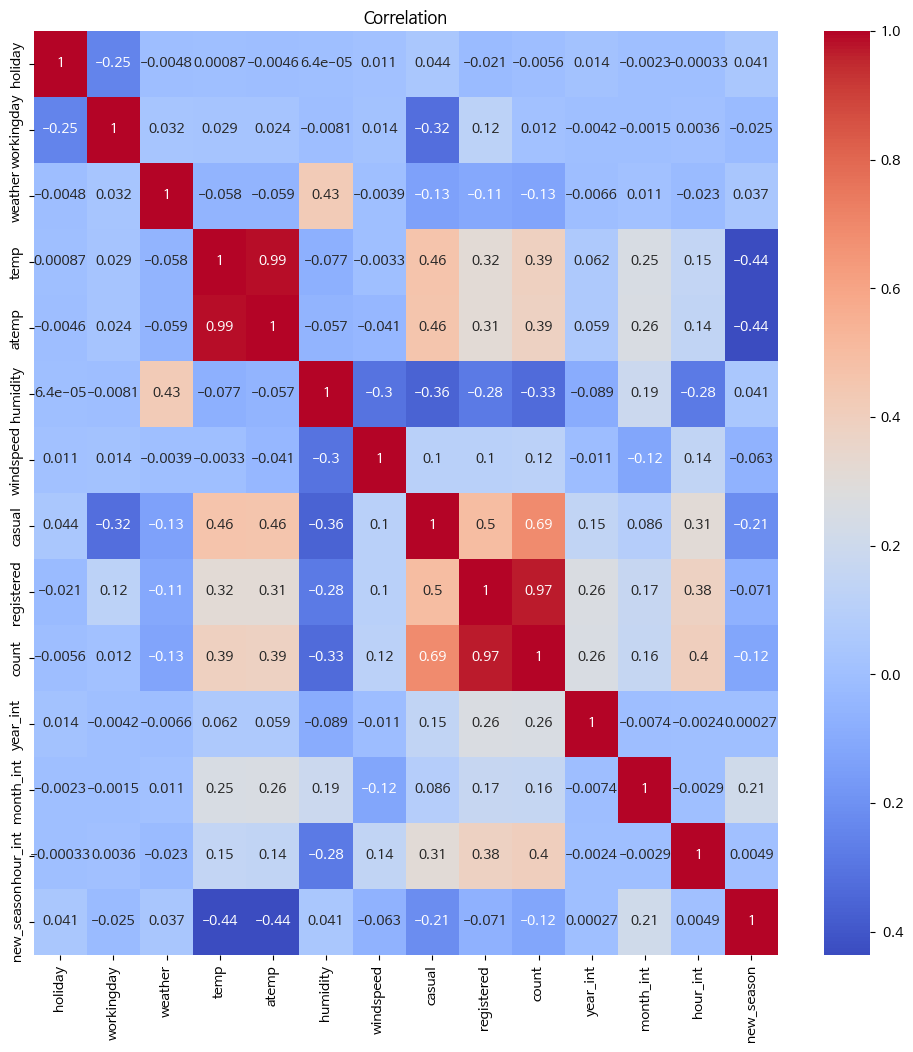

In [52]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm")   # annot=True 수치를 함께 표시, cmap="coolwarm":직관적으로 색상 구분
plt.title("Correlation")
plt.show()

In [53]:
df_train.loc[df_train['temp'] >= 30 , 'month_int']

,month_int
2243,6
2244,6
2245,6
2246,6
2247,6
...,...
9226,9
9241,9
9242,9
9245,9


In [54]:
count_by_month = df_train.loc[df_train['temp'] >= 30 , 'month_int'].value_counts().sort_index()
print(count_by_month)

month_int
4       8
5       9
6     190
7     511
8     397
9     104
10      2
Name: count, dtype: int64


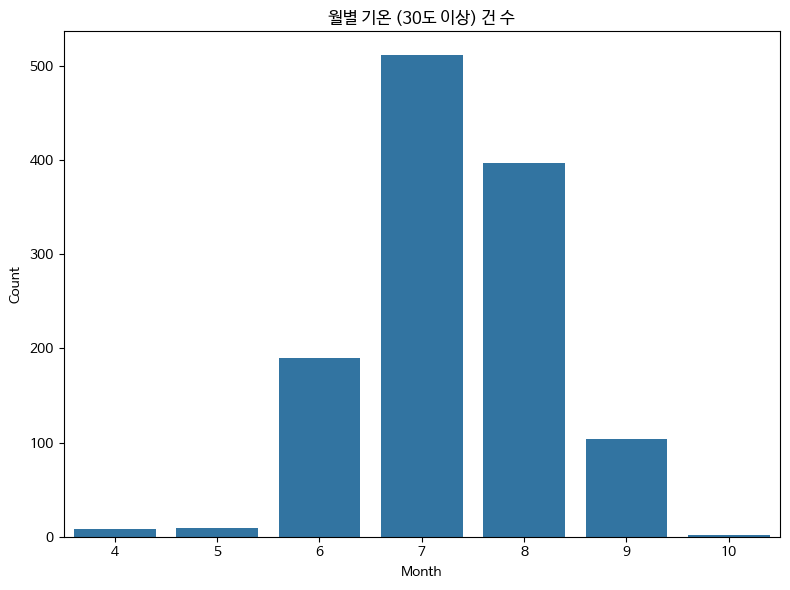

In [55]:
filter_hot_month = df_train[df_train['temp']>= 30]

count_by_filter_month = filter_hot_month.groupby('month_int').size().reset_index(name='count')


plt.figure(figsize=(8,6))
sns.barplot(x='month_int', y='count', data=count_by_filter_month)
plt.title('월별 기온 (30도 이상) 건 수')
plt.xlabel('Month')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


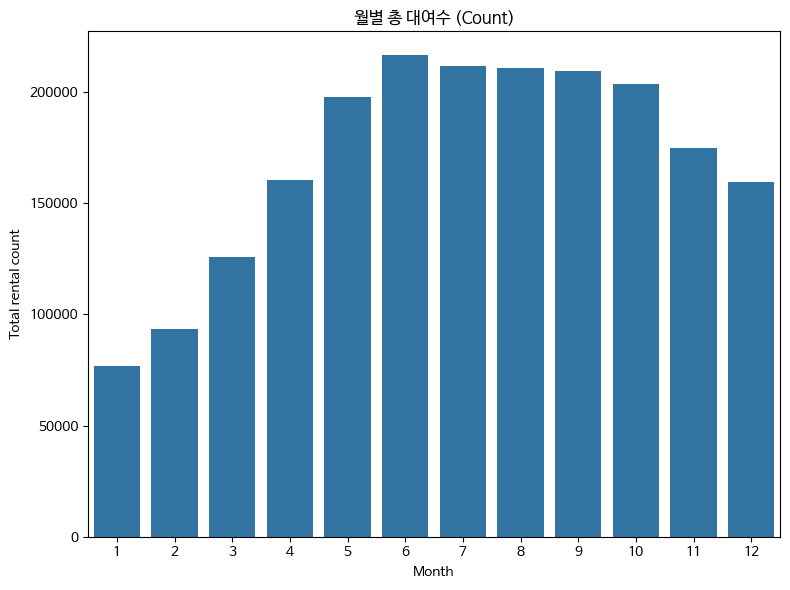

In [56]:
total_month = df_train.groupby('month_int')['count'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='month_int', y='count', data=total_month)
plt.title('월별 총 대여수 (Count)')
plt.xlabel('Month')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

계절에 따른 대여량 추이가 따뜻해지는 봄에 올라가고, 여름에 최고치, 가을에 내려오고, 겨울에 제일 낮다

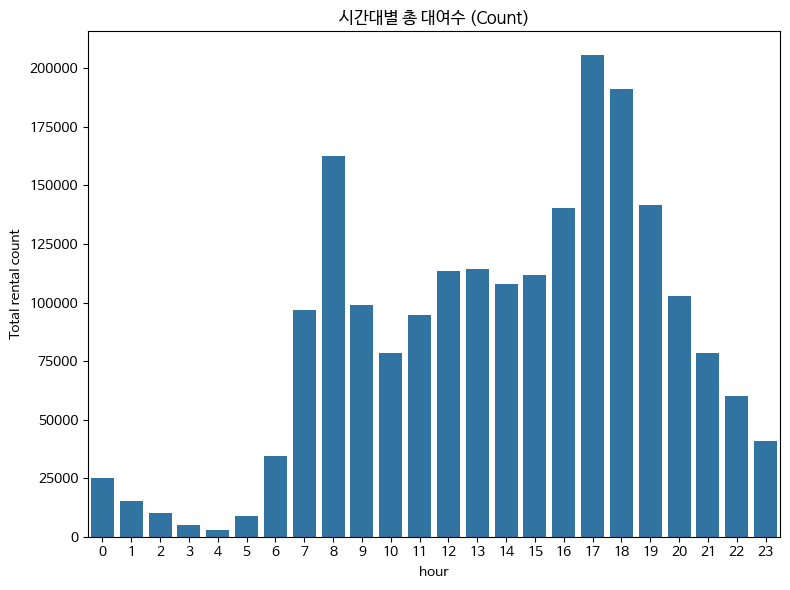

In [58]:
total_hour = df_train.groupby('hour_int')['count'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='hour_int', y='count', data=total_hour)
plt.title('시간대별 총 대여수 (Count)')
plt.xlabel('hour')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

출퇴근 시간(07 \~ 09시, 16 \~ 19시)가 가장 이용량이 많다.

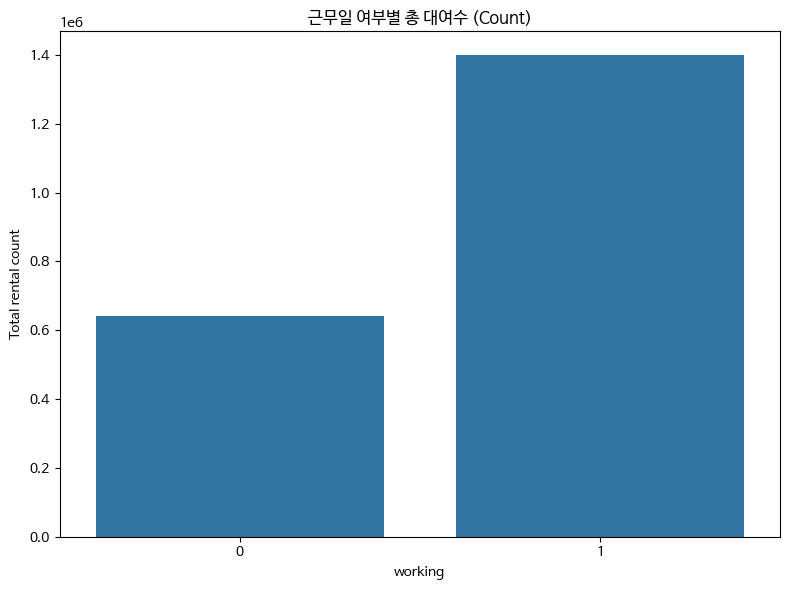

In [59]:
total_workingday = df_train.groupby('workingday')['count'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='workingday', y='count', data=total_workingday)
plt.title('근무일 여부별 총 대여수 (Count)')
plt.xlabel('working')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

근무일(1)에 더 많이 사용한다.

출/퇴근에 많이 쓰는 분석이랑 연관있다.

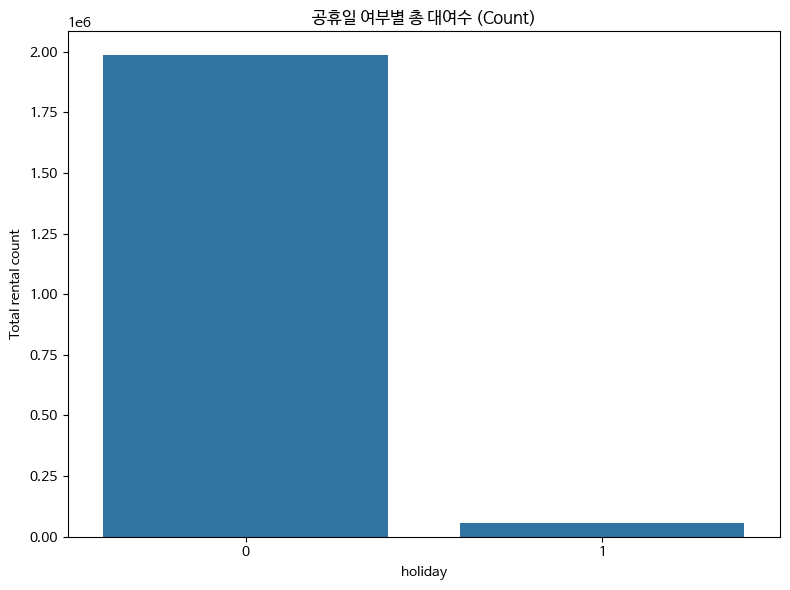

In [60]:
total_holiday = df_train.groupby('holiday')['count'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='holiday', y='count', data=total_holiday)
plt.title('공휴일 여부별 총 대여수 (Count)')
plt.xlabel('holiday')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

평일(0)에 더 많이 사용한다.

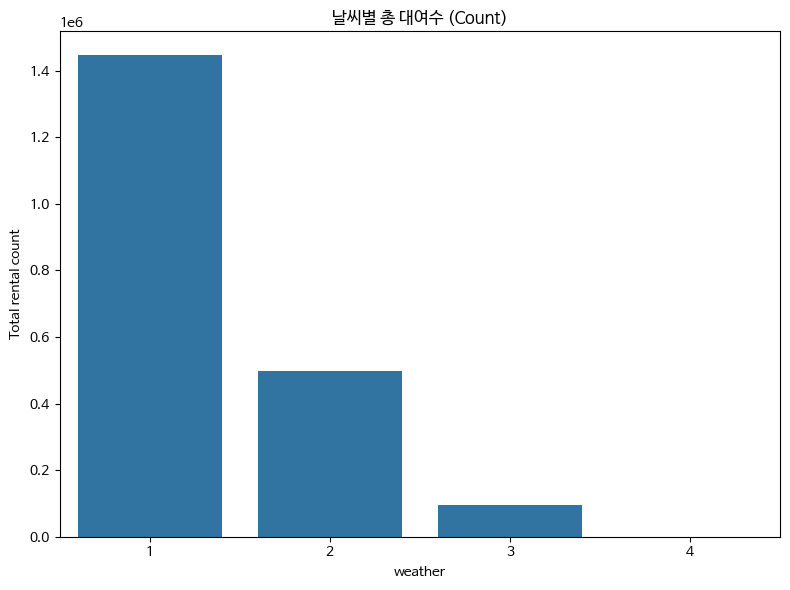

In [61]:
total_weather = df_train.groupby('weather')['count'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='weather', y='count', data=total_weather)
plt.title('날씨별 총 대여수 (Count)')
plt.xlabel('weather')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

맑은 날에 더 많이 이용한다.

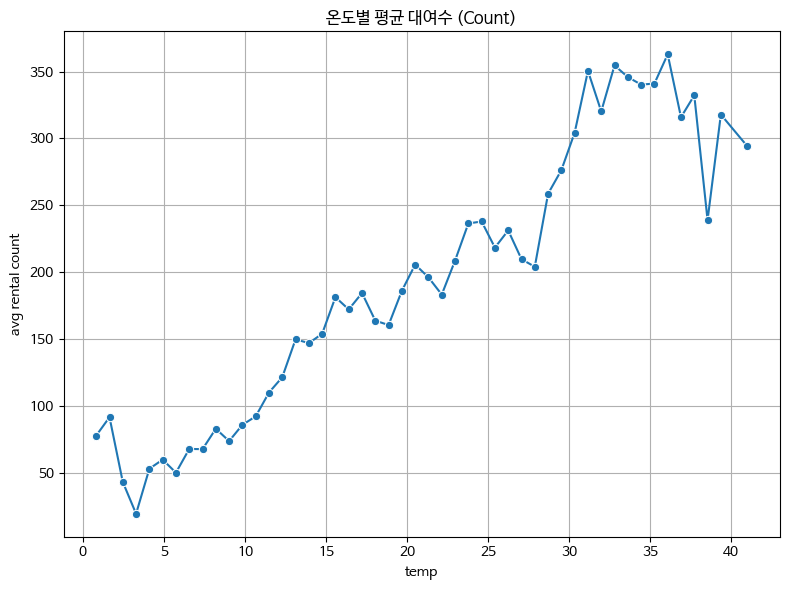

In [62]:
temp_avg = df_train.groupby('temp')['count'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(data=temp_avg, x='temp', y='count', marker='o')
plt.title('온도별 평균 대여수 (Count)')
plt.xlabel('temp')
plt.ylabel('avg rental count')
plt.grid(True)
plt.tight_layout()
plt.show()

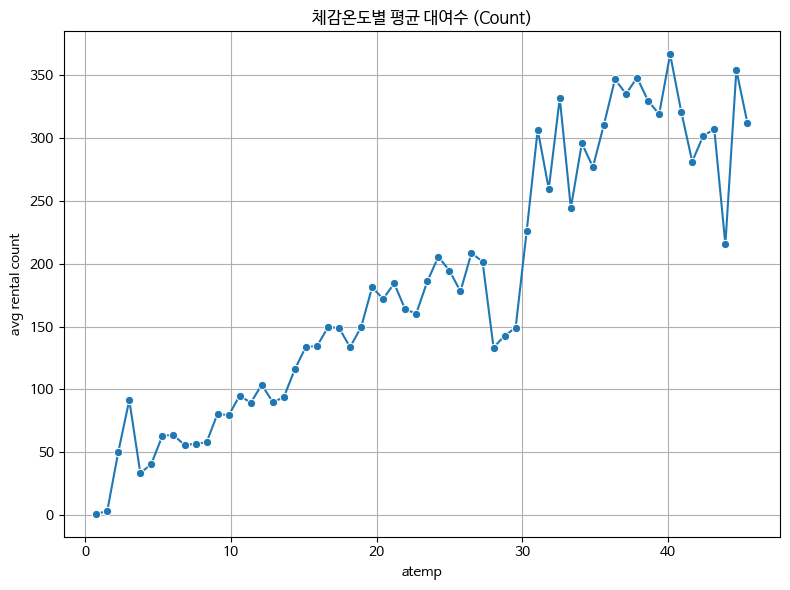

In [63]:
atemp_avg = df_train.groupby('atemp')['count'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(data=atemp_avg, x='atemp', y='count', marker='o')
plt.title('체감온도별 평균 대여수 (Count)')
plt.xlabel('atemp')
plt.ylabel('avg rental count')
plt.grid(True)
plt.tight_layout()
plt.show()

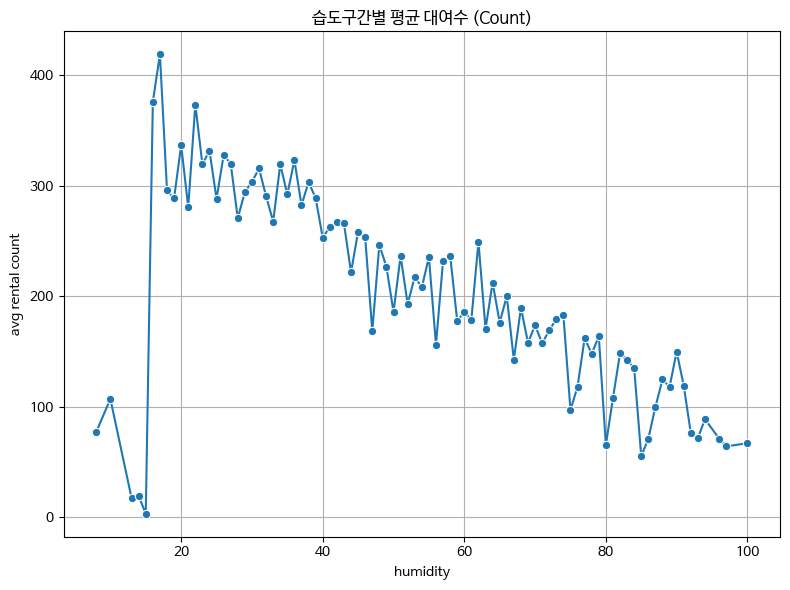

In [110]:
humidity_avg = df_train.groupby('humidity')['count'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(data=humidity_avg, x='humidity', y='count', marker='o')
plt.title('습도구간별 평균 대여수 (Count)')
plt.xlabel('humidity')
plt.ylabel('avg rental count')
plt.grid(True)
plt.tight_layout()
plt.show()

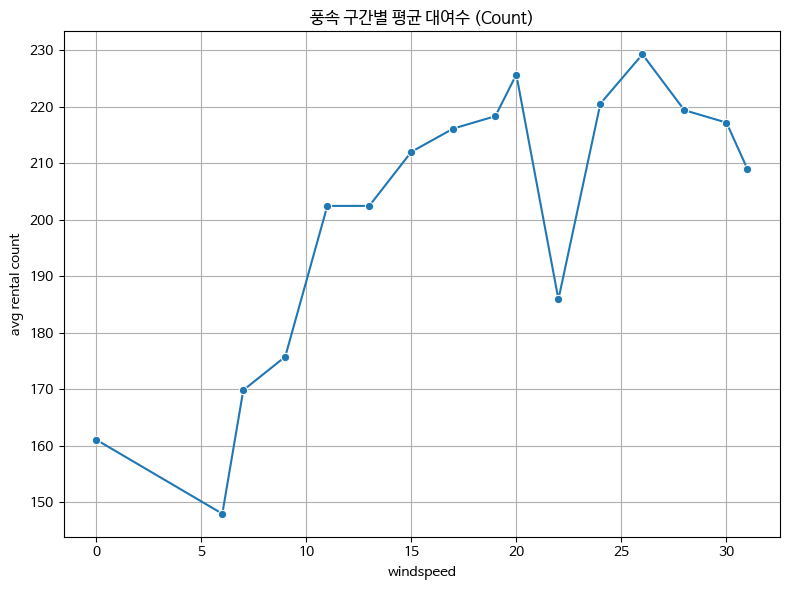

In [112]:
windspeed_avg = df_train.groupby('windspeed')['count'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(data=windspeed_avg, x='windspeed', y='count', marker='o')
plt.title('풍속 구간별 평균 대여수 (Count)')
plt.xlabel('windspeed')
plt.ylabel('avg rental count')
plt.grid(True)
plt.tight_layout()
plt.show()

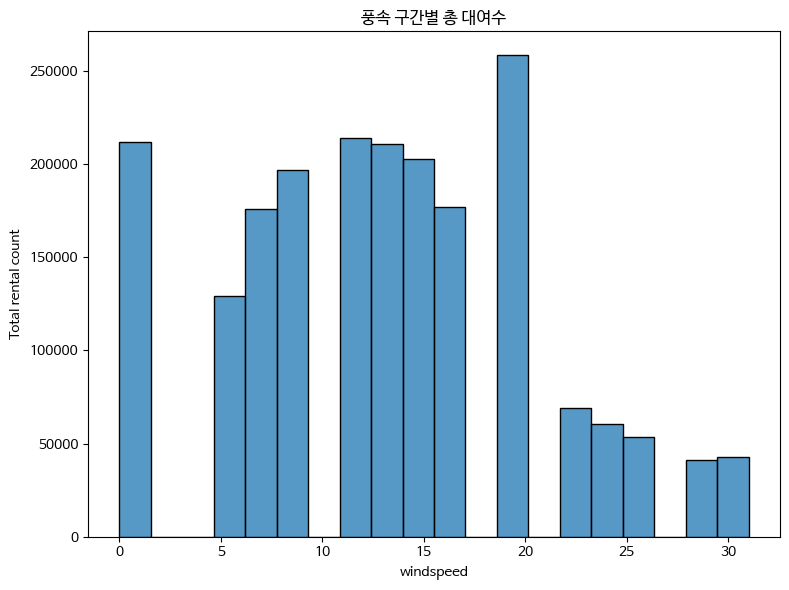

In [66]:
plt.figure(figsize=(8,6))

sns.histplot(x='windspeed', data=df_train, weights=df_train['count'], bins=20, kde=False)

plt.title('풍속 구간별 총 대여수')
plt.xlabel('windspeed')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

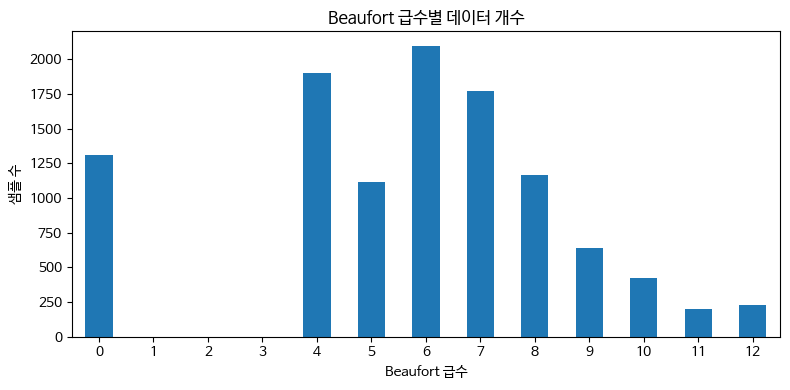

In [67]:
counts.plot(kind='bar', figsize=(8,4))
plt.xlabel('Beaufort 급수')
plt.ylabel('샘플 수')
plt.title('Beaufort 급수별 데이터 개수')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

쾌적한 환경 (적절한 온도, 습도, 풍속)에서 대여량이 많다.

___

# 4. 모델링

### 1) 모델링 준비

In [68]:
# df -> np array
data_train_np = df_train.values

In [69]:
data_train_np

array([[Timestamp('2011-01-01 00:00:00'), 0, 0, ..., False, False, False],
       [Timestamp('2011-01-01 01:00:00'), 0, 0, ..., False, False, False],
       [Timestamp('2011-01-01 02:00:00'), 0, 0, ..., False, False, False],
       ...,
       [Timestamp('2012-12-19 21:00:00'), 0, 1, ..., False, False, False],
       [Timestamp('2012-12-19 22:00:00'), 0, 1, ..., False, False, False],
       [Timestamp('2012-12-19 23:00:00'), 0, 1, ..., False, False, False]],
      dtype=object)

In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 10885
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10638 non-null  datetime64[ns]
 1   holiday     10638 non-null  int64         
 2   workingday  10638 non-null  int64         
 3   weather     10638 non-null  int64         
 4   temp        10638 non-null  float64       
 5   atemp       10638 non-null  float64       
 6   humidity    10638 non-null  int64         
 7   windspeed   10638 non-null  float64       
 8   casual      10638 non-null  int64         
 9   registered  10638 non-null  int64         
 10  count       10638 non-null  int64         
 11  year_int    10638 non-null  int32         
 12  month_int   10638 non-null  int32         
 13  hour_int    10638 non-null  int32         
 14  new_season  10638 non-null  int64         
 15  bf_0        10638 non-null  bool          
 16  bf_1        10638 non-null 

In [71]:
df_train.describe(include = 'all')

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
count,10638,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,...,10638,10638,10638,10638,10638,10638,10638,10638,10638,10638
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2,2,2,2,2,2,2,2,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10638,8733,9519,8541,8864,9472,9995,10217,10438,10638
mean,2011-12-29 13:31:24.940778240,0.028671,0.680015,1.414176,20.277618,23.722575,62.337187,12.284399,36.087610,155.795074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2011-01-01 00:00:00,0.000000,0.000000,1.000000,0.820000,0.760000,8.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2011-07-04 16:15:00,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2012-01-02 16:30:00,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,11.001400,17.000000,118.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2012-07-03 03:45:00,0.000000,1.000000,2.000000,26.240000,31.060000,78.000000,16.997900,49.000000,223.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2012-12-19 23:00:00,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,31.000900,367.000000,886.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2) 데이터 분할

In [72]:
# 독립변수와 종속변수 나누기
y = df_train['count']
X = df_train.drop(['count', 'datetime', 'casual', 'registered', 'windspeed'], axis=1)

In [73]:
print(X.shape)
print(y.shape)

(10638, 23)
(10638,)


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2, random_state=42)

In [75]:
X_train.shape

(8510, 23)

In [76]:
X_train

,holiday,workingday,weather,temp,atemp,humidity,year_int,month_int,hour_int,new_season,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
0,0,0,1,9.84,14.395,81,2011,1,0,4,...,False,False,False,False,False,False,False,False,False,False
1,0,0,1,9.02,13.635,80,2011,1,1,4,...,False,False,False,False,False,False,False,False,False,False
2,0,0,1,9.02,13.635,80,2011,1,2,4,...,False,False,False,False,False,False,False,False,False,False
3,0,0,1,9.84,14.395,75,2011,1,3,4,...,False,False,False,False,False,False,False,False,False,False
4,0,0,1,9.84,14.395,75,2011,1,4,4,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8736,0,1,3,28.70,33.335,79,2012,8,9,2,...,False,False,False,True,False,False,False,False,False,False
8737,0,1,1,30.34,34.850,70,2012,8,10,2,...,False,False,False,False,True,False,False,False,False,False
8738,0,1,1,31.16,36.365,66,2012,8,11,2,...,False,False,True,False,False,False,False,False,False,False
8739,0,1,2,31.98,36.365,55,2012,8,12,2,...,False,True,False,False,False,False,False,False,False,False


### 3) 베이스라인 모델

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.linear_model import LinearRegression

In [78]:
def print_linear_regr(y_test, y_pred):
    val_mae = mean_absolute_error(y_test, y_pred)
    val_mse = mean_squared_error(y_test, y_pred)
    val_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    val_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    val_r2 = r2_score(y_test, y_pred)
    print(f"MAE:{val_mae:.3f}, R2:{val_r2:.3f}\nMSE:{val_mse:.3f}, RMSE:{val_rmse:.3f}, RMSLE:{val_rmsle:.3f}, ")

다중 선형 회귀

In [79]:
model_multiple = LinearRegression()
model_multiple.fit(X_train, y_train)

LinearRegression()

In [80]:
y_pred_multiple = model_multiple.predict(X_test)

In [81]:
print_linear_regr(y_test, y_pred_multiple)

MAE:139.460, R2:0.286
MSE:33852.268, RMSE:183.990, RMSLE:1.221, 


### 4) 범주형 변수 처리 (One-Hot Encoding)

범주형 변수들을 각각 0/1 더미 변수로 바꾼다.

✅ 선형모델은 숫자의 크고 작음을 선형적 관계로 해석하므로,
순서형으로 하면 잘못 해석한다.

➡️ 각 값마다 One-Hot Encoding하면 모델이 올바르게 학습한다.

In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 10885
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10638 non-null  datetime64[ns]
 1   holiday     10638 non-null  int64         
 2   workingday  10638 non-null  int64         
 3   weather     10638 non-null  int64         
 4   temp        10638 non-null  float64       
 5   atemp       10638 non-null  float64       
 6   humidity    10638 non-null  int64         
 7   windspeed   10638 non-null  float64       
 8   casual      10638 non-null  int64         
 9   registered  10638 non-null  int64         
 10  count       10638 non-null  int64         
 11  year_int    10638 non-null  int32         
 12  month_int   10638 non-null  int32         
 13  hour_int    10638 non-null  int32         
 14  new_season  10638 non-null  int64         
 15  bf_0        10638 non-null  bool          
 16  bf_1        10638 non-null 

In [83]:
df_proc = pd.get_dummies(
    df_train,
    #columns=['new_season','holiday','workingday','weather', 'year_int', 'month_int', 'day_int', 'hour_int'],
    columns=['new_season','holiday','workingday','weather', 'year_int', 'month_int', 'hour_int'],
    drop_first=False
)

print(df_proc.columns)

Index(['datetime', 'temp', 'atemp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'bf_0', 'bf_1', 'bf_2', 'bf_3', 'bf_4', 'bf_5',
       'bf_6', 'bf_7', 'bf_8', 'bf_9', 'bf_10', 'bf_11', 'bf_12',
       'new_season_1', 'new_season_2', 'new_season_3', 'new_season_4',
       'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'year_int_2011', 'year_int_2012',
       'month_int_1', 'month_int_2', 'month_int_3', 'month_int_4',
       'month_int_5', 'month_int_6', 'month_int_7', 'month_int_8',
       'month_int_9', 'month_int_10', 'month_int_11', 'month_int_12',
       'hour_int_0', 'hour_int_1', 'hour_int_2', 'hour_int_3', 'hour_int_4',
       'hour_int_5', 'hour_int_6', 'hour_int_7', 'hour_int_8', 'hour_int_9',
       'hour_int_10', 'hour_int_11', 'hour_int_12', 'hour_int_13',
       'hour_int_14', 'hour_int_15', 'hour_int_16', 'hour_int_17',
       'hour_int_18', 'hour_int_19', 'hour_int_20', 'hour_int_21

In [84]:
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 10885
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       10638 non-null  datetime64[ns]
 1   temp           10638 non-null  float64       
 2   atemp          10638 non-null  float64       
 3   humidity       10638 non-null  int64         
 4   windspeed      10638 non-null  float64       
 5   casual         10638 non-null  int64         
 6   registered     10638 non-null  int64         
 7   count          10638 non-null  int64         
 8   bf_0           10638 non-null  bool          
 9   bf_1           10638 non-null  bool          
 10  bf_2           10638 non-null  bool          
 11  bf_3           10638 non-null  bool          
 12  bf_4           10638 non-null  bool          
 13  bf_5           10638 non-null  bool          
 14  bf_6           10638 non-null  bool          
 15  bf_7           10638 non

In [85]:
# 독립변수와 종속변수 나누기
y = df_proc['count']
X = df_proc.drop(['count', 'datetime', 'casual', 'registered', 'windspeed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2, random_state=42)

### 5) 수치형 변수 처리 (정규화 Z-score (StandardScaler))

수치형 변수는 StandardScaler로 표준화

In [86]:
df_proc

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,bf_0,bf_1,...,hour_int_14,hour_int_15,hour_int_16,hour_int_17,hour_int_18,hour_int_19,hour_int_20,hour_int_21,hour_int_22,hour_int_23
0,2011-01-01 00:00:00,9.84,14.395,81,0.0000,3,13,16,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2011-01-01 01:00:00,9.02,13.635,80,0.0000,8,32,40,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2011-01-01 02:00:00,9.02,13.635,80,0.0000,5,27,32,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-01 03:00:00,9.84,14.395,75,0.0000,3,10,13,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2011-01-01 04:00:00,9.84,14.395,75,0.0000,0,1,1,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,15.58,19.695,50,26.0027,7,329,336,False,False,...,False,False,False,False,False,True,False,False,False,False
10882,2012-12-19 20:00:00,14.76,17.425,57,15.0013,10,231,241,False,False,...,False,False,False,False,False,False,True,False,False,False
10883,2012-12-19 21:00:00,13.94,15.910,61,15.0013,4,164,168,False,False,...,False,False,False,False,False,False,False,True,False,False
10884,2012-12-19 22:00:00,13.94,17.425,61,6.0032,12,117,129,False,False,...,False,False,False,False,False,False,False,False,True,False


In [87]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8510 entries, 0 to 8740
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           8510 non-null   float64
 1   atemp          8510 non-null   float64
 2   humidity       8510 non-null   int64  
 3   bf_0           8510 non-null   bool   
 4   bf_1           8510 non-null   bool   
 5   bf_2           8510 non-null   bool   
 6   bf_3           8510 non-null   bool   
 7   bf_4           8510 non-null   bool   
 8   bf_5           8510 non-null   bool   
 9   bf_6           8510 non-null   bool   
 10  bf_7           8510 non-null   bool   
 11  bf_8           8510 non-null   bool   
 12  bf_9           8510 non-null   bool   
 13  bf_10          8510 non-null   bool   
 14  bf_11          8510 non-null   bool   
 15  bf_12          8510 non-null   bool   
 16  new_season_1   8510 non-null   bool   
 17  new_season_2   8510 non-null   bool   
 18  new_season_3 

In [88]:
num_cols = ['temp','atemp','humidity'] # 스케일할 수치형 변수
cat_cols = [c for c in X_train.columns if c not in num_cols] # 범주형 변수

In [89]:
from sklearn.preprocessing import StandardScaler        # Z-score

# 수치형만
# 정규화 - Z-score
scaler = StandardScaler()
X_train_scaled_numtype = scaler.fit_transform(X_train[num_cols])
X_test_scaled_numtype = scaler.fit_transform(X_test[num_cols])

In [90]:
X_train_scaled_numtype

array([[-1.28859924, -1.06342602,  1.00860491],
       [-1.39067292, -1.15062798,  0.95672965],
       [-1.39067292, -1.15062798,  0.95672965],
       ...,
       [ 1.36531643,  1.45739898,  0.23047609],
       [ 1.46739011,  1.45739898, -0.34015171],
       [ 1.56946379,  1.54402724, -0.65140324]])

In [91]:
X_train_scaled = np.hstack([X_train_scaled_numtype, X_train[cat_cols].values])
X_test_scaled = np.hstack([X_test_scaled_numtype, X_test[cat_cols].values])

In [92]:
X_train_scaled

array([[-1.28859924, -1.06342602,  1.00860491, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39067292, -1.15062798,  0.95672965, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39067292, -1.15062798,  0.95672965, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.36531643,  1.45739898,  0.23047609, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.46739011,  1.45739898, -0.34015171, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.56946379,  1.54402724, -0.65140324, ...,  0.        ,
         0.        ,  0.        ]])

In [93]:
X_test_scaled

array([[ 1.92997873,  1.91283811, -1.14751812, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.92997873,  1.91283811, -1.14751812, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.05172157,  1.91283811, -1.44240733, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.99184945, -1.10622142, -0.26285049, ...,  1.        ,
         0.        ,  0.        ],
       [-0.99184945, -0.89803411, -0.26285049, ...,  0.        ,
         1.        ,  0.        ],
       [-1.11359229, -1.00247131,  0.03203871, ...,  0.        ,
         0.        ,  1.        ]])

###  6) Ridge /Lasso

- Ridge : 모든 계수를 작게 억제
- Lasso : 일부 계수를 0으로 만들어 자동으로 feature 선택

In [94]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 모델 정의
ridge_alpha = 0.01
lasso_alpha = 0.01
elasticnet_alpha = 0.01
elasticnet_l1_ratio = 0.8

model_ridge = Ridge(alpha= ridge_alpha)
model_lasso = Lasso(alpha= lasso_alpha)
model_elastic = ElasticNet(alpha= elasticnet_alpha, l1_ratio= elasticnet_l1_ratio)

In [95]:
model_ridge.fit(X_train_scaled, y_train)
model_ridge_score = model_ridge.score(X_test_scaled, y_test)

In [96]:
model_lasso.fit(X_train_scaled, y_train)
model_lasso_score = model_lasso.score(X_test_scaled, y_test)

In [97]:
model_elastic.fit(X_train_scaled, y_train)
model_elastic_score = model_elastic.score(X_test_scaled, y_test)

In [98]:
print(f"Ridge (alpha:{ridge_alpha}) score : {model_ridge_score:.3f} -> {model_ridge_score*100:.1f}% 설명함")
print(f"Lasso (alpha:{lasso_alpha}) score : {model_lasso_score:.3f} -> {model_lasso_score*100:.1f}% 설명함")
print(f"ElasticNet (alpha:{elasticnet_alpha}, l1_ratio:{elasticnet_l1_ratio}): {model_elastic_score:.3f} -> {model_elastic_score*100:.1f}% 설명함")

Ridge (alpha:0.01) score : 0.646 -> 64.6% 설명함
Lasso (alpha:0.01) score : 0.646 -> 64.6% 설명함
ElasticNet (alpha:0.01, l1_ratio:0.8): 0.635 -> 63.5% 설명함


.score()는 R^2를 return 한다.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score

In [99]:
y_pred = model_ridge.predict(X_test_scaled)
y_pred = np.maximum(0, model_ridge.predict(X_test_scaled))
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print("Ridge RMSLE:", rmsle)

Ridge RMSLE: 0.9746330254767592


___

### 7) 개념 : RMSLE

#### 로그함수의 특징
1. 0 < x < 1 범위 에서는 기울기가 매우 가파르다.
로그함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을 넓은 범위로 펼칠 수 있는 특징을 가진다.

2. 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 이에 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징이 있다.

✅ 결과적으로 데이터의 분포를 밀집되어있는 부분은 퍼지게, 퍼져있는 부분은 모아지게 만들 수 있다.

❗️한쪽으로 몰려있는 (skewed) 분포에 로그 변환을 취하게 되면 넓게 펼칠 수 있다.


$$ log(y_i +1) $$ 는 np.log1p()를 사용하면 된다.
np.log(x + 1)보다 np.log1p(x)가 낫다.

In [100]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    return result_df

result_df = get_top_error_data(y_test, y_pred_multiple, n_tops=5)

      real_count  predicted_count   diff
1182         834            182.0  652.0
1158         817            169.0  648.0
992          839            196.0  643.0
1134         835            206.0  629.0
826          809            181.0  628.0


In [101]:
error_idx = result_df.sort_values('diff', ascending=False).index[:10]
cols = ['datetime', 'holiday', 'workingday', 'weather']
df_train.loc[error_idx, cols]

,datetime,holiday,workingday,weather
1182,2011-03-13 23:00:00,0,0,1
1158,2011-03-12 22:00:00,0,0,1
992,2011-03-05 19:00:00,0,0,2
1134,2011-03-11 22:00:00,0,1,1
826,2011-02-17 21:00:00,0,1,1
602,2011-02-08 06:00:00,0,1,1
778,2011-02-15 20:00:00,0,1,1
1143,2011-03-12 07:00:00,0,0,1
1001,2011-03-06 04:00:00,0,0,2
835,2011-02-18 06:00:00,0,1,2


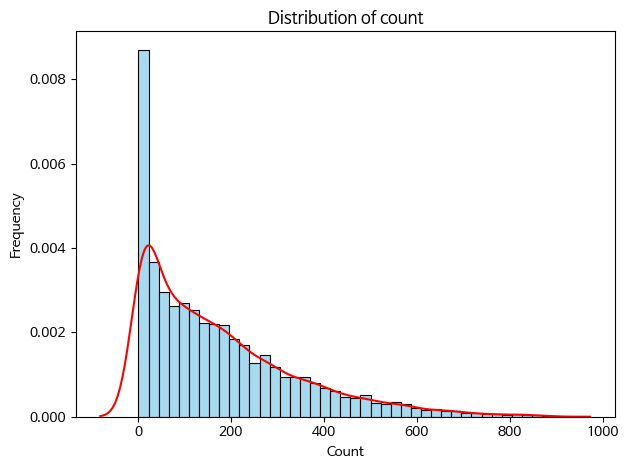

In [102]:
sns.histplot(y_train, stat='density', color='skyblue', edgecolor='black')
sns.kdeplot(y_train, color='red')
plt.title(f"Distribution of count")
plt.xlabel("Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

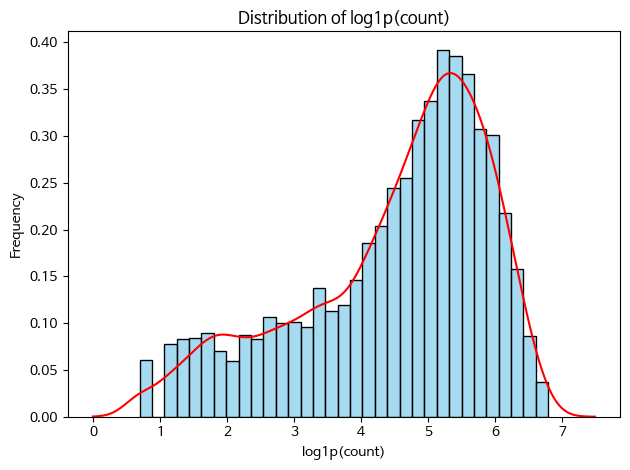

In [103]:
y_log_train = np.log1p(y_train)
#y_log_train.hist()

sns.histplot(y_log_train, stat='density', color='skyblue', edgecolor='black')
sns.kdeplot(y_log_train, color='red')
plt.title(f"Distribution of log1p(count)")
plt.xlabel("log1p(count)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

y_train의 쏠림 왜곡 (skewed)이 어느정도는 해결되었다.

### 8) Log

In [104]:
# 독립변수와 종속변수 나누기
y = df_proc['count']
X = df_proc.drop(['count', 'datetime', 'casual', 'registered', 'windspeed'], axis=1)

y_log_train = np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_log_train, shuffle=False, test_size = 0.2, random_state=42)

#lr_reg = LinearRegression()
lr_reg = Ridge(alpha=0.001)
lr_reg.fit(X_train, y_train)
y_pred_log = lr_reg.predict(X_test)

print_linear_regr(y_test, y_pred_log)

MAE:0.432, R2:0.821
MSE:0.330, RMSE:0.575, RMSLE:0.124, 


In [105]:
# 로그 변환된 y_test를 다시 원래 스케일로 변환 (empm1)
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred_log)
print_linear_regr(y_test_exp, y_pred_exp)

MAE:82.343, R2:0.700
MSE:14204.422, RMSE:119.182, RMSLE:0.575, 


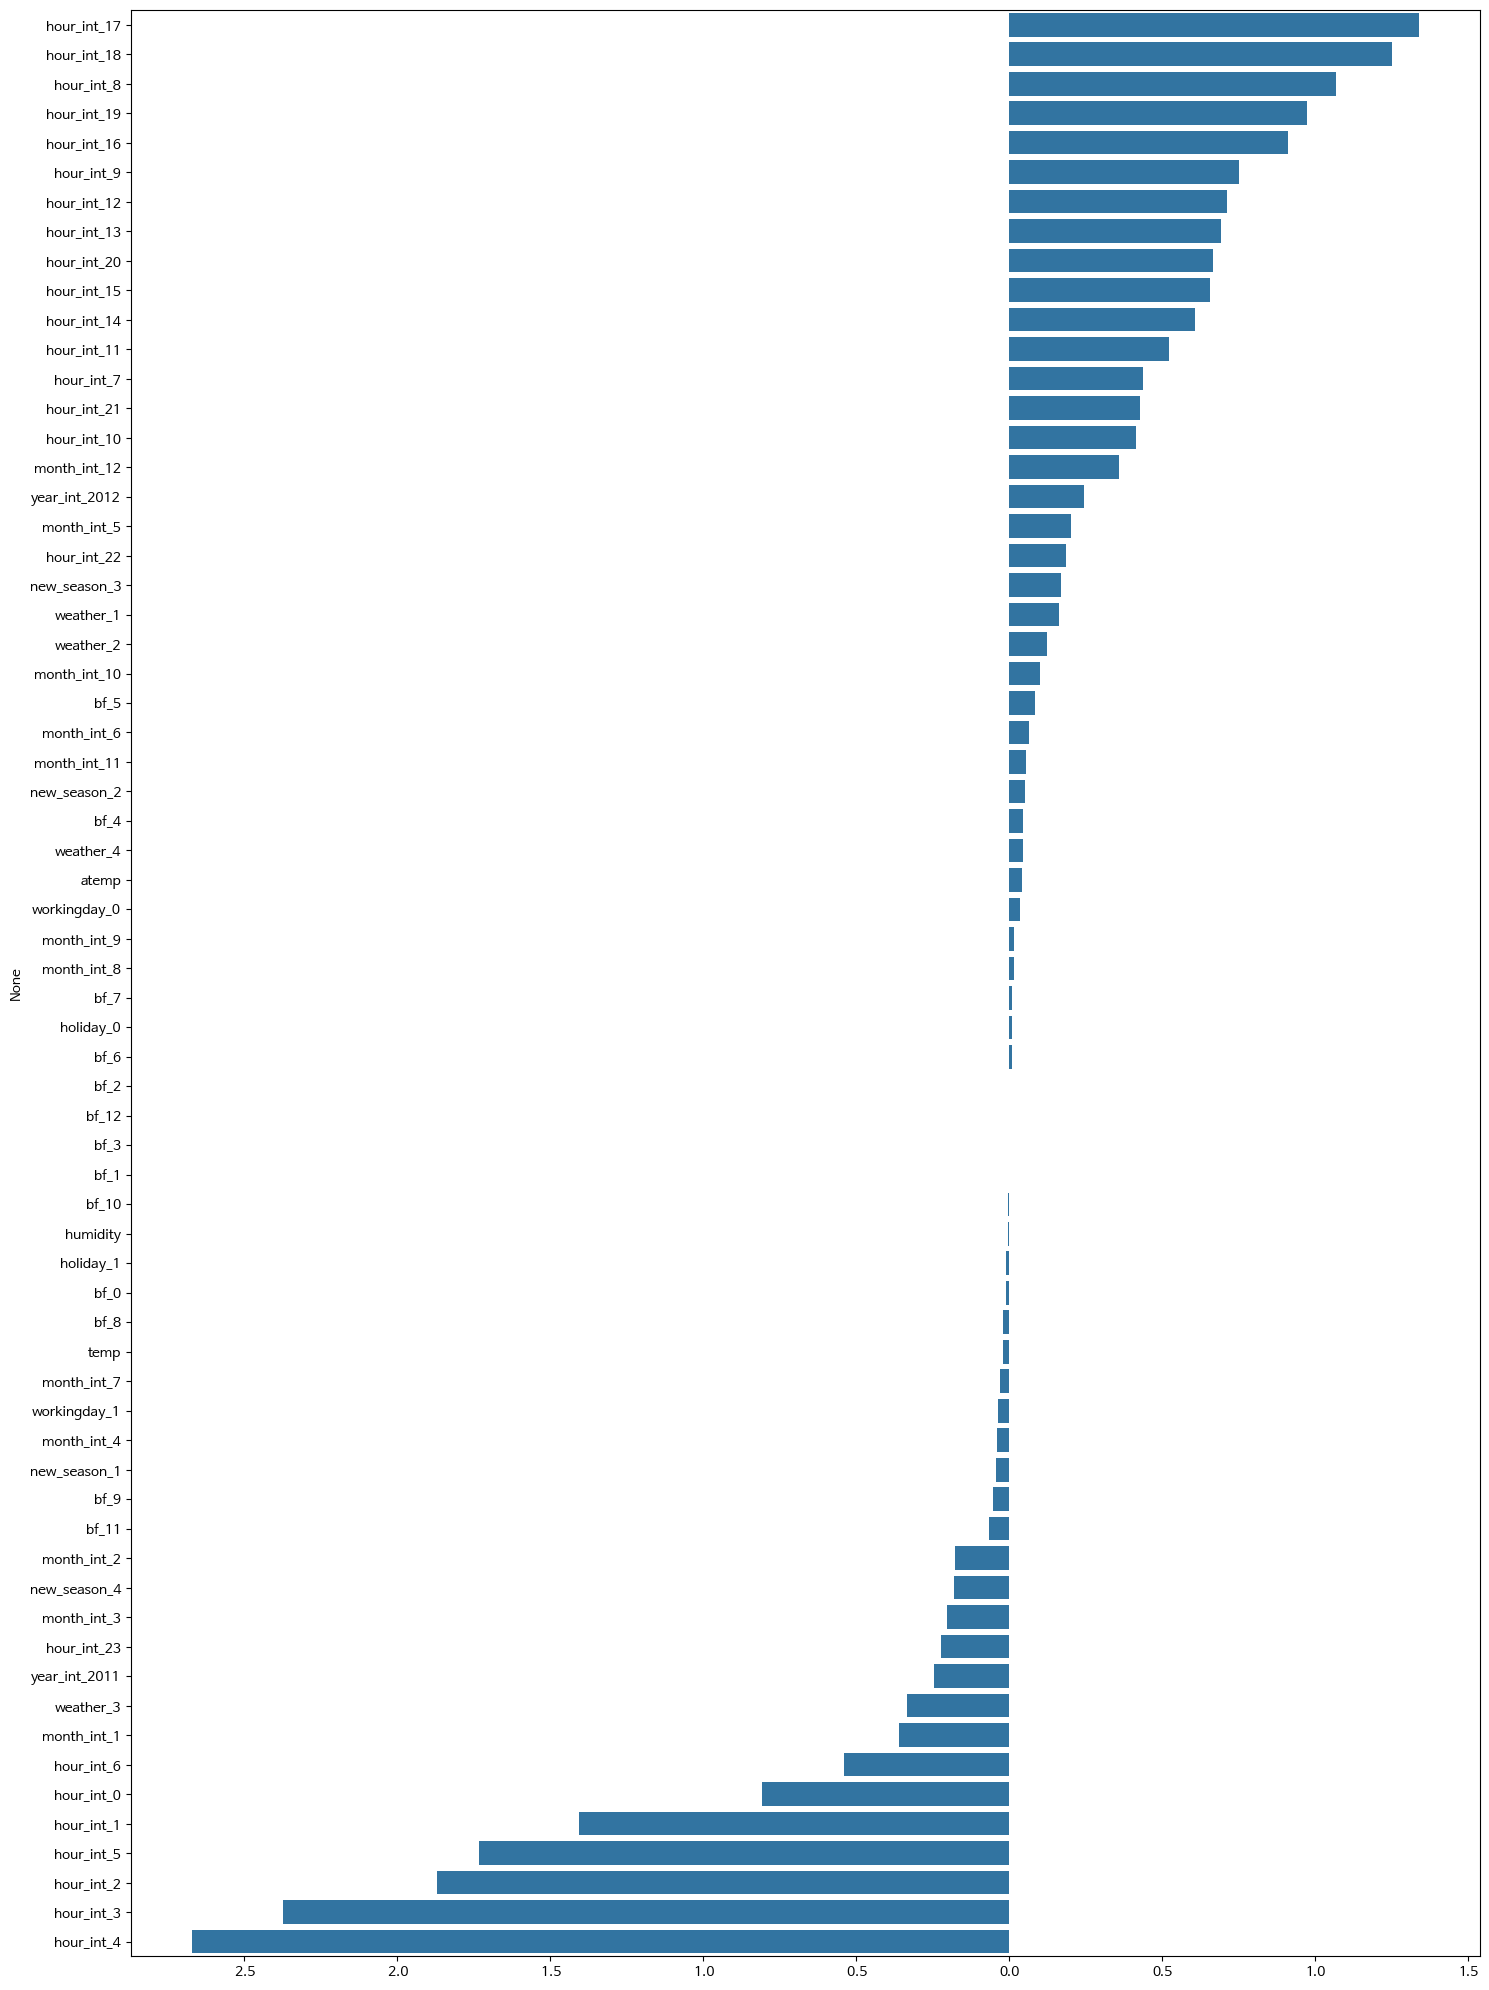

In [106]:
plt.figure(figsize=(15,20))
coef = pd.Series(lr_reg.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.tight_layout()
plt.show()

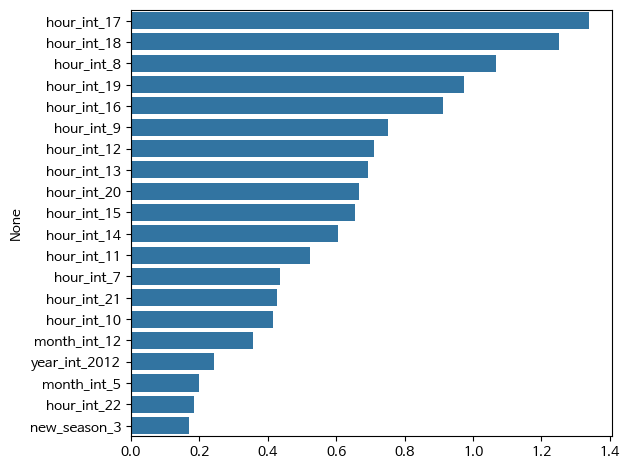

In [796]:
coef = pd.Series(lr_reg.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.tight_layout()
plt.show()

- Ridge 의 alpha=0.001 일 때,
대여 수요 관여 top 20

In [798]:
for feature, val in coef_sort.items():
    print(f"{feature} : {val:.4f}")

hour_int_17 : 1.3380
hour_int_18 : 1.2506
hour_int_8 : 1.0685
hour_int_19 : 0.9736
hour_int_16 : 0.9126
hour_int_9 : 0.7516
hour_int_12 : 0.7115
hour_int_13 : 0.6929
hour_int_20 : 0.6657
hour_int_15 : 0.6554
hour_int_14 : 0.6067
hour_int_11 : 0.5236
hour_int_7 : 0.4363
hour_int_21 : 0.4269
hour_int_10 : 0.4144
month_int_12 : 0.3577
year_int_2012 : 0.2442
month_int_5 : 0.2006
hour_int_22 : 0.1847
new_season_3 : 0.1709


____

### 9) K-Fold

In [799]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV    # K-Fold, cross value, score, gridsearch
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # 음수 예측을 0으로
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# 성능 평가
ridge_scores = cross_val_score(model_ridge, X_train_scaled, y_train, cv=kf, scoring=rmsle_scorer)
lasso_scores = cross_val_score(model_lasso, X_train_scaled, y_train, cv=kf, scoring=rmsle_scorer)

ridge_pos = -ridge_scores
lasso_pos = -lasso_scores

# 결과 출력
print("Ridge: ", ridge_scores)
print("Lasso: ", lasso_scores)

Ridge:  [-0.14537293 -0.14394385 -0.14209443 -0.14017574 -0.14269957]
Lasso:  [-0.15797609 -0.15834253 -0.15205425 -0.15284038 -0.15661864]


In [801]:
print("Ridge RMSLE 평균:",  np.mean(-ridge_scores))
print("Ridge RMSLE 표준편차:", np.std(-ridge_scores))

print("Lasso RMSLE 평균:",  np.mean(-lasso_scores))
print("Lasso RMSLE 표준편차:", np.std(-lasso_scores))

Ridge RMSLE 평균: 0.14285730707338998
Ridge RMSLE 표준편차: 0.0017496618457604187
Lasso RMSLE 평균: 0.15556637869850487
Lasso RMSLE 표준편차: 0.002622483519116996


____

### 10) GridSearchCV

In [802]:
print_linear_regr(y_test, y_pred_multiple)

MAE:235.264, R2:-33543.477
MSE:61897.227, RMSE:248.792, RMSLE:3.676, 


In [809]:
# 그리드 서치할 때 알파값
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}

In [810]:
# Ridge모델 그리드 서치
ridge_grid = GridSearchCV(Ridge(), param_grid_ridge, scoring=rmsle_scorer, cv=kf)
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             scoring=make_scorer(rmsle, greater_is_better=False, response_method='predict'))

In [811]:
# Lasso모델 그리드 서치
lasso_grid = GridSearchCV(Lasso(), param_grid_lasso, scoring=rmsle_scorer, cv=kf)
lasso_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             scoring=make_scorer(rmsle, greater_is_better=False, response_method='predict'))

In [812]:
# 결과 출력
print("Ridge 최적 alpha: ", ridge_grid.best_params_['alpha'])
print("Ridge R제곱 점수: ", ridge_grid.best_score_)

Ridge 최적 alpha:  0.001
Ridge R제곱 점수:  -0.14285689098267906


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#ridge

alpha must be a non-negative float i.e. in [0, inf)

In [813]:
# 결과 출력
print("Lasso 최적 alpha: ", lasso_grid.best_params_['alpha'])
print("Lasso R제곱 점수: ", lasso_grid.best_score_)

Lasso 최적 alpha:  0.001
Lasso R제곱 점수:  -0.1433448387215549


____

## 11) 최종 모델 재학습

In [814]:
final_model = ridge_grid.best_estimator_  # Ridge 객체
final_model.fit(X_train_scaled, y_train)  # 전체 학습 데이터로

Ridge(alpha=0.001)

In [816]:
y_pred_log = final_model.predict(X_test_scaled)

y_pred = np.expm1(y_pred_log)
y_pred = np.maximum(0, y_pred)

y_true     = np.expm1(y_test)

final_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print("Test RMSLE:", final_rmsle)

Test RMSLE: 0.5802498749580584


최종 모델

    Ridge
    alpha : 0.001

최종 모델 예측 성능

    핵심 지표 : RMSLE
    달성 RMSLE값 : 0.580

____

# 테스트 데이터 예측 (test.csv)

In [657]:
df_test = pd.read_csv("/content/drive/MyDrive/(개인)AI_3기/Data/미션3/test.csv")

In [658]:
df_train_original = pd.read_csv("/content/drive/MyDrive/(개인)AI_3기/Data/미션3/train.csv")

In [659]:
df_train_original

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [660]:
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


test.csv로도 한번돌린다.

train.csv로 컬럼, dtype 바꾼게 있으면 test.csv도 똑같이 작업해줘야한다.

test.csv 예측 수치 (count, registered, casual)한다.

____

In [661]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [662]:
df_test.describe(include = 'all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
unique,6493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,NaN,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,NaN,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,NaN,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,NaN,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900


beaufort 풍속 계급으로 원핫인코딩

In [663]:
# 0–12급 Beaufort 기준(m/s)
bins = [0, 0.3, 1.5, 3.3, 5.5, 8.0, 10.8, 13.9, 17.2, 20.7, 24.5, 28.4, 32.6, np.inf]
labels = list(range(13))

df_test['beaufort'] = pd.cut(
    df_test['windspeed'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# one-hot 인코딩
df_test = pd.get_dummies(df_test, columns=['beaufort'], prefix='bf')

In [664]:
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,bf_0,...,bf_3,bf_4,bf_5,bf_6,bf_7,bf_8,bf_9,bf_10,bf_11,bf_12
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,False,...,False,False,False,False,False,False,False,True,False,False
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,True,...,False,False,False,False,False,False,False,False,False,False
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,True,...,False,False,False,False,False,False,False,False,False,False
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,False,...,False,False,False,True,False,False,False,False,False,False
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,False,...,False,False,False,True,False,False,False,False,False,False
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,False,...,False,False,False,True,False,False,False,False,False,False
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,False,...,False,False,False,True,False,False,False,False,False,False
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,False,...,False,False,True,False,False,False,False,False,False,False


In [665]:
bf_cols = [c for c in df_test.columns if c.startswith('bf_')]
counts = df_test[bf_cols].sum()
counts.index = counts.index.str.replace('bf_', '').astype(int)
counts = counts.sort_index()

print(counts)

0      867
1        0
2        0
3        0
4     1136
5      618
6     1253
7     1023
8      688
9      416
10     255
11     122
12     115
dtype: int64


datetime(object) -> int로 변경

In [666]:
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

df_test['year_int'] = df_test['datetime'].dt.year
df_test['month_int'] = df_test['datetime'].dt.month
#df_test['day_int'] = df_test['datetime'].dt.day
df_test['hour_int'] = df_test['datetime'].dt.hour

In [667]:
#print(df_test[['datetime', 'season', 'year_int', 'month_int', 'day_int', 'hour_int']])
print(df_test[['datetime', 'season', 'year_int', 'month_int', 'hour_int']])

                datetime  season  year_int  month_int  hour_int
0    2011-01-20 00:00:00       1      2011          1         0
1    2011-01-20 01:00:00       1      2011          1         1
2    2011-01-20 02:00:00       1      2011          1         2
3    2011-01-20 03:00:00       1      2011          1         3
4    2011-01-20 04:00:00       1      2011          1         4
...                  ...     ...       ...        ...       ...
6488 2012-12-31 19:00:00       1      2012         12        19
6489 2012-12-31 20:00:00       1      2012         12        20
6490 2012-12-31 21:00:00       1      2012         12        21
6491 2012-12-31 22:00:00       1      2012         12        22
6492 2012-12-31 23:00:00       1      2012         12        23

[6493 rows x 5 columns]


season 오류 변경

In [668]:
def mapping_new_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

df_test['new_season'] = df_test['month_int'].apply(mapping_new_season)

print(df_test[['month_int', 'season', 'new_season']].drop_duplicates())

      month_int  season  new_season
0             1       1           4
257           2       1           4
460           3       1           1
484           3       2           1
744           4       2           1
1008          5       2           1
1296          6       2           2
1320          6       3           2
1560          7       3           2
1848          8       3           2
2123          9       3           3
2195          9       4           3
2387         10       4           3
2675         11       4           3
2938         12       4           4
2962         12       1           4


In [669]:
df_test = df_test.drop(columns=['season'])

In [670]:
df_test = pd.get_dummies(
    df_test,
    #columns=['new_season','holiday','workingday','weather', 'year_int', 'month_int', 'day_int', 'hour_int'],
    columns=['new_season','holiday','workingday','weather', 'year_int', 'month_int', 'hour_int'],
    drop_first=False
)

print(df_test.columns)

Index(['datetime', 'temp', 'atemp', 'humidity', 'windspeed', 'bf_0', 'bf_1',
       'bf_2', 'bf_3', 'bf_4', 'bf_5', 'bf_6', 'bf_7', 'bf_8', 'bf_9', 'bf_10',
       'bf_11', 'bf_12', 'new_season_1', 'new_season_2', 'new_season_3',
       'new_season_4', 'holiday_0', 'holiday_1', 'workingday_0',
       'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_int_2011', 'year_int_2012', 'month_int_1', 'month_int_2',
       'month_int_3', 'month_int_4', 'month_int_5', 'month_int_6',
       'month_int_7', 'month_int_8', 'month_int_9', 'month_int_10',
       'month_int_11', 'month_int_12', 'hour_int_0', 'hour_int_1',
       'hour_int_2', 'hour_int_3', 'hour_int_4', 'hour_int_5', 'hour_int_6',
       'hour_int_7', 'hour_int_8', 'hour_int_9', 'hour_int_10', 'hour_int_11',
       'hour_int_12', 'hour_int_13', 'hour_int_14', 'hour_int_15',
       'hour_int_16', 'hour_int_17', 'hour_int_18', 'hour_int_19',
       'hour_int_20', 'hour_int_21', 'hour_int_22', 'hour_int_23'],

In [671]:
train_cols = set(X_train.columns)
test_cols  = set(df_test.columns)

# train에는 있지만 test에 없는 컬럼
missing_in_test = train_cols - test_cols
print("Test에 누락된 cols:")
for c in sorted(missing_in_test):
    print(c)

# test에는 있지만 train에는 없는 컬럼
extra_in_test = test_cols - train_cols
print("\nTest에만 있는 cols:")
for c in sorted(extra_in_test):
    print(c)

Test에 누락된 cols:

Test에만 있는 cols:
datetime
windspeed


In [673]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       6493 non-null   datetime64[ns]
 1   temp           6493 non-null   float64       
 2   atemp          6493 non-null   float64       
 3   humidity       6493 non-null   int64         
 4   windspeed      6493 non-null   float64       
 5   bf_0           6493 non-null   bool          
 6   bf_1           6493 non-null   bool          
 7   bf_2           6493 non-null   bool          
 8   bf_3           6493 non-null   bool          
 9   bf_4           6493 non-null   bool          
 10  bf_5           6493 non-null   bool          
 11  bf_6           6493 non-null   bool          
 12  bf_7           6493 non-null   bool          
 13  bf_8           6493 non-null   bool          
 14  bf_9           6493 non-null   bool          
 15  bf_10          6493 n

In [674]:
df_test.describe(include = 'all')

,datetime,temp,atemp,humidity,windspeed,bf_0,bf_1,bf_2,bf_3,bf_4,...,hour_int_14,hour_int_15,hour_int_16,hour_int_17,hour_int_18,hour_int_19,hour_int_20,hour_int_21,hour_int_22,hour_int_23
count,6493,6493.000000,6493.000000,6493.000000,6493.000000,6493,6493,6493,6493,6493,...,6493,6493,6493,6493,6493,6493,6493,6493,6493,6493
unique,NaN,NaN,NaN,NaN,NaN,2,1,1,1,2,...,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,NaN,NaN,NaN,NaN,NaN,5626,6493,6493,6493,5357,...,6220,6220,6219,6219,6221,6221,6221,6221,6221,6221
mean,2012-01-13 09:27:47.765285632,20.620607,24.012865,64.125212,12.631157,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2011-01-20 00:00:00,0.820000,0.000000,16.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2011-07-22 15:00:00,13.940000,16.665000,49.000000,7.001500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2012-01-20 23:00:00,21.320000,25.000000,65.000000,11.001400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2012-07-20 17:00:00,27.060000,31.060000,81.000000,16.997900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2012-12-31 23:00:00,40.180000,50.000000,100.000000,55.998600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


모델링 준비

In [675]:
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 10885
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       10638 non-null  datetime64[ns]
 1   temp           10638 non-null  float64       
 2   atemp          10638 non-null  float64       
 3   humidity       10638 non-null  int64         
 4   windspeed      10638 non-null  float64       
 5   casual         10638 non-null  int64         
 6   registered     10638 non-null  int64         
 7   count          10638 non-null  int64         
 8   bf_0           10638 non-null  bool          
 9   bf_1           10638 non-null  bool          
 10  bf_2           10638 non-null  bool          
 11  bf_3           10638 non-null  bool          
 12  bf_4           10638 non-null  bool          
 13  bf_5           10638 non-null  bool          
 14  bf_6           10638 non-null  bool          
 15  bf_7           10638 non

In [676]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10638 entries, 0 to 10885
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10638 non-null  datetime64[ns]
 1   holiday     10638 non-null  int64         
 2   workingday  10638 non-null  int64         
 3   weather     10638 non-null  int64         
 4   temp        10638 non-null  float64       
 5   atemp       10638 non-null  float64       
 6   humidity    10638 non-null  int64         
 7   windspeed   10638 non-null  float64       
 8   casual      10638 non-null  int64         
 9   registered  10638 non-null  int64         
 10  count       10638 non-null  int64         
 11  year_int    10638 non-null  int32         
 12  month_int   10638 non-null  int32         
 13  hour_int    10638 non-null  int32         
 14  new_season  10638 non-null  int64         
 15  bf_0        10638 non-null  bool          
 16  bf_1        10638 non-null 

In [677]:
dt_col_datetime = df_test["datetime"].copy()

In [678]:
X_test_ready = df_test.drop(['datetime','windspeed'], axis=1)

In [679]:
X_test_scaled_num = scaler.transform(X_test_ready[num_cols])
X_test_dummy      = X_test_ready.drop(num_cols, axis=1).values
X_test_final      = np.hstack([X_test_scaled_num, X_test_dummy])

In [680]:
y_pred_log = final_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log).clip(0)
y_pred = np.round(y_pred).astype(int)

In [681]:
mission3 = pd.DataFrame({
    'datetime': df_test["datetime"],
    'count':    y_pred
})
mission3.to_csv('/content/drive/MyDrive/(개인)AI_3기/Data/미션3/submission5.csv', index=False)

____

In [682]:
df_result = pd.read_csv("/content/drive/MyDrive/(개인)AI_3기/Data/미션3/submission5.csv")

In [683]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  6493 non-null   object
 1   count     6493 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 101.6+ KB


In [684]:
df_result['datetime'] = pd.to_datetime(df_result['datetime'])

df_result['year_int'] = df_result['datetime'].dt.year
df_result['month_int'] = df_result['datetime'].dt.month
df_result['day_int'] = df_result['datetime'].dt.day
df_result['hour_int'] = df_result['datetime'].dt.hour

In [685]:
df_result

,datetime,count,year_int,month_int,day_int,hour_int
0,2011-01-20 00:00:00,13,2011,1,20,0
1,2011-01-20 01:00:00,8,2011,1,20,1
2,2011-01-20 02:00:00,4,2011,1,20,2
3,2011-01-20 03:00:00,2,2011,1,20,3
4,2011-01-20 04:00:00,1,2011,1,20,4
...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,290,2012,12,31,19
6489,2012-12-31 20:00:00,213,2012,12,31,20
6490,2012-12-31 21:00:00,174,2012,12,31,21
6491,2012-12-31 22:00:00,155,2012,12,31,22


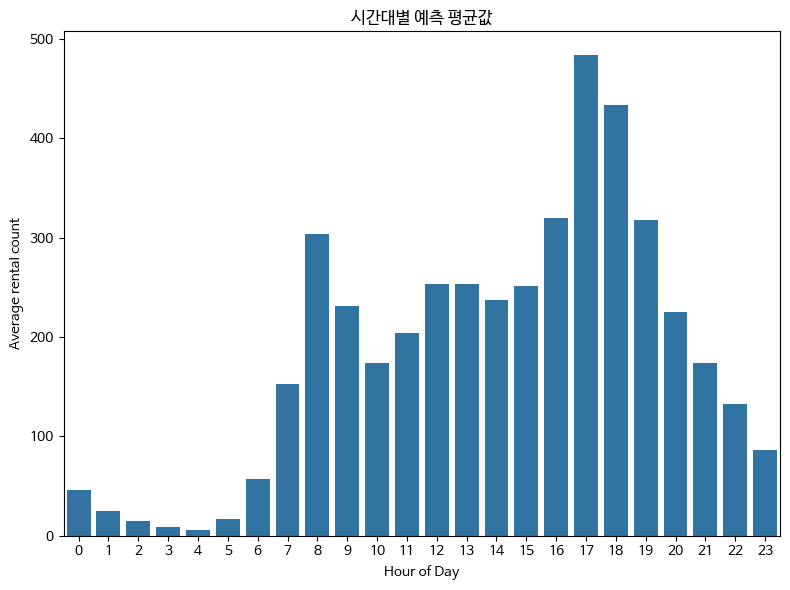

In [686]:
#시간대별로 그래프

agg = df_result.groupby('hour_int')[['count']].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='hour_int', y='count', data=agg)
plt.title('시간대별 예측 평균값')
plt.xlabel('Hour of Day')
plt.ylabel('Average rental count')
plt.tight_layout()
plt.show()

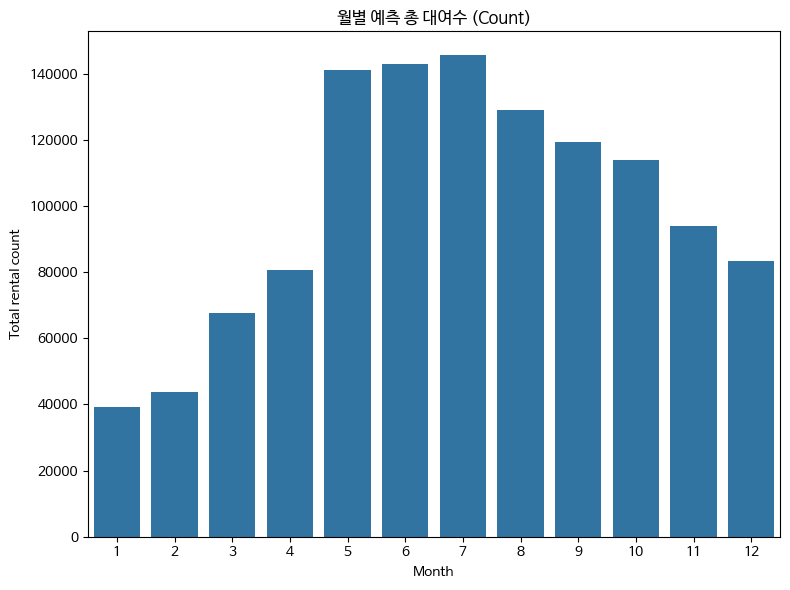

In [692]:
total_month = df_result.groupby('month_int')['count'].sum().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='month_int', y='count', data=total_month)
plt.title('월별 예측 총 대여수 (Count)')
plt.xlabel('Month')
plt.ylabel('Total rental count')
plt.tight_layout()
plt.show()

결론

    EDA를 통해 주요 피처의 패턴이 모델의 성능에 영향
    외부적 요소 (계절, 날씨, 온도, 습도, 풍속)
     - 쾌적한 상태에서 자전거를 이용하려는 성향이 있음
    시간적 요소 (주중/주말, 출/퇴근)
     - 등록회원은 주로 주중에는 출/퇴근시간대와 주말엔 낮시간대에 이용
     - 비등록회원은 낮시간대에 이용

제언

    운영 측면
     - 출퇴근 시간대(평일 07 ~ 09시, 17 ~ 19시) 주말 낮(10 ~ 15시)에 자전거가 많은 대여소에서 대여하거나, 적게 있는 대여소에서 반납하면 포인트 적립
     → 자전거를 운반하는 비용 감소

     - 계절, 날씨 등을 고려해 운영량 조절 및 전략 필요

     - GPS 등 위치 정보 취득
        - 상업, 주거 지역, 교통 환승 구역 등에서 대여 수요를 파악 가능
     → 더욱 다양한 수요 예측 가능

     - 관리자 웹, 이용자 앱 활용하여 UX 적극 활용
